# Load HCP parcellated task data
## (version with Behavioural Data)

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [1]:
# !pip install nilearn --quiet

In [2]:
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchview import draw_graph

np.random.seed(0)
torch.manual_seed(0)

In [3]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [4]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [5]:
# # @title Download data file
# import os, requests

# fname = "hcp_task.tgz"
# url = "https://osf.io/2y3fw/download"

# if not os.path.isfile(fname):
#   try:
#     r = requests.get(url)
#   except requests.ConnectionError:
#     print("!!! Failed to download data !!!")
#   else:
#     if r.status_code != requests.codes.ok:
#       print("!!! Failed to download data !!!")
#     else:
#       with open(fname, "wb") as fid:
#         fid.write(r.content)

In [6]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
# import tarfile

# # open file
# with tarfile.open(fname) as tfile:
#   # extracting file
#   tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')
print(subjects.shape)

(100,)


## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [7]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

In [8]:
print(regions.shape)
print(regions[0][:10])
print(regions[1][:10])
print(regions[2][:10])

(3, 360)
['R_V1' 'R_MST' 'R_V6' 'R_V2' 'R_V3' 'R_V4' 'R_V8' 'R_4' 'R_3b' 'R_FEF']
['Visual1' 'Visual2' 'Visual2' 'Visual2' 'Visual2' 'Visual2' 'Visual2'
 'Somatomotor' 'Somatomotor' 'Cingulo-Oper']
['2.209' '2.05561' '2.1498' '2.15347' '2.07251' '2.0378' '2.04079'
 '2.16893' '2.10655' '1.87217']


# Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task.

**An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.**

In [9]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that ctheory of mind (ToM) conditionorrespond to this specific trial
    frames = [np.arange(s, min(315,s+d)) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

In [10]:
for cond in EXPERIMENTS['LANGUAGE']['cond']:
    print(cond)

math
story


In [11]:
load_evs(subjects[0], "LANGUAGE", 0)[0]

[array([41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
        58]),
 array([59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
        76]),
 array([118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 133, 134, 135]),
 array([136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
        149, 150, 151, 152, 153]),
 array([194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
        207, 208, 209, 210]),
 array([211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
        224, 225, 226, 227, 228]),
 array([228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240,
        241]),
 array([242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254,
        255, 256, 257, 258]),
 array([305, 306, 307, 308, 309, 310, 311, 312, 313, 314])]

# Example run



In [12]:
my_exp = 'LANGUAGE'
my_subj = subjects[3]
my_run = 0

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)

evs = load_evs(my_subj, my_exp, my_run)
# print(data.shape)
# print(data[0])

In [13]:
def mask_extracted_L(subject_id , my_run = 0):
  evs = load_evs(subject=subject_id, experiment= "LANGUAGE", run=my_run)
  math_mask = np.zeros([316])
  story_mask = np.zeros([316])
  for i in evs[0]:
    math_mask[i] = 1
  for i in evs[1]:
    story_mask[i] = 1
  return {
      'math' : math_mask,
      'story' : story_mask
  }

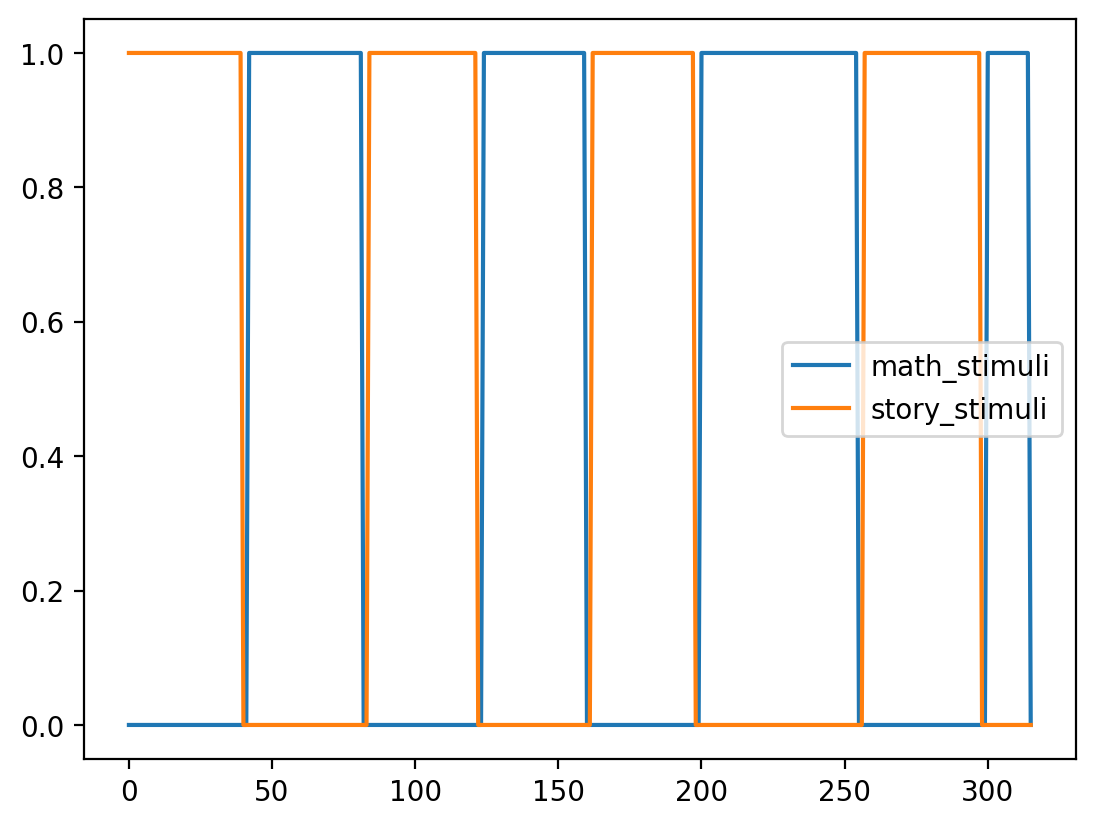

In [14]:
temp = mask_extracted_L(my_subj)

plt.plot(temp['math'],label = 'math_stimuli')
plt.plot(temp['story'],label = 'story_stimuli')
plt.legend()
del temp

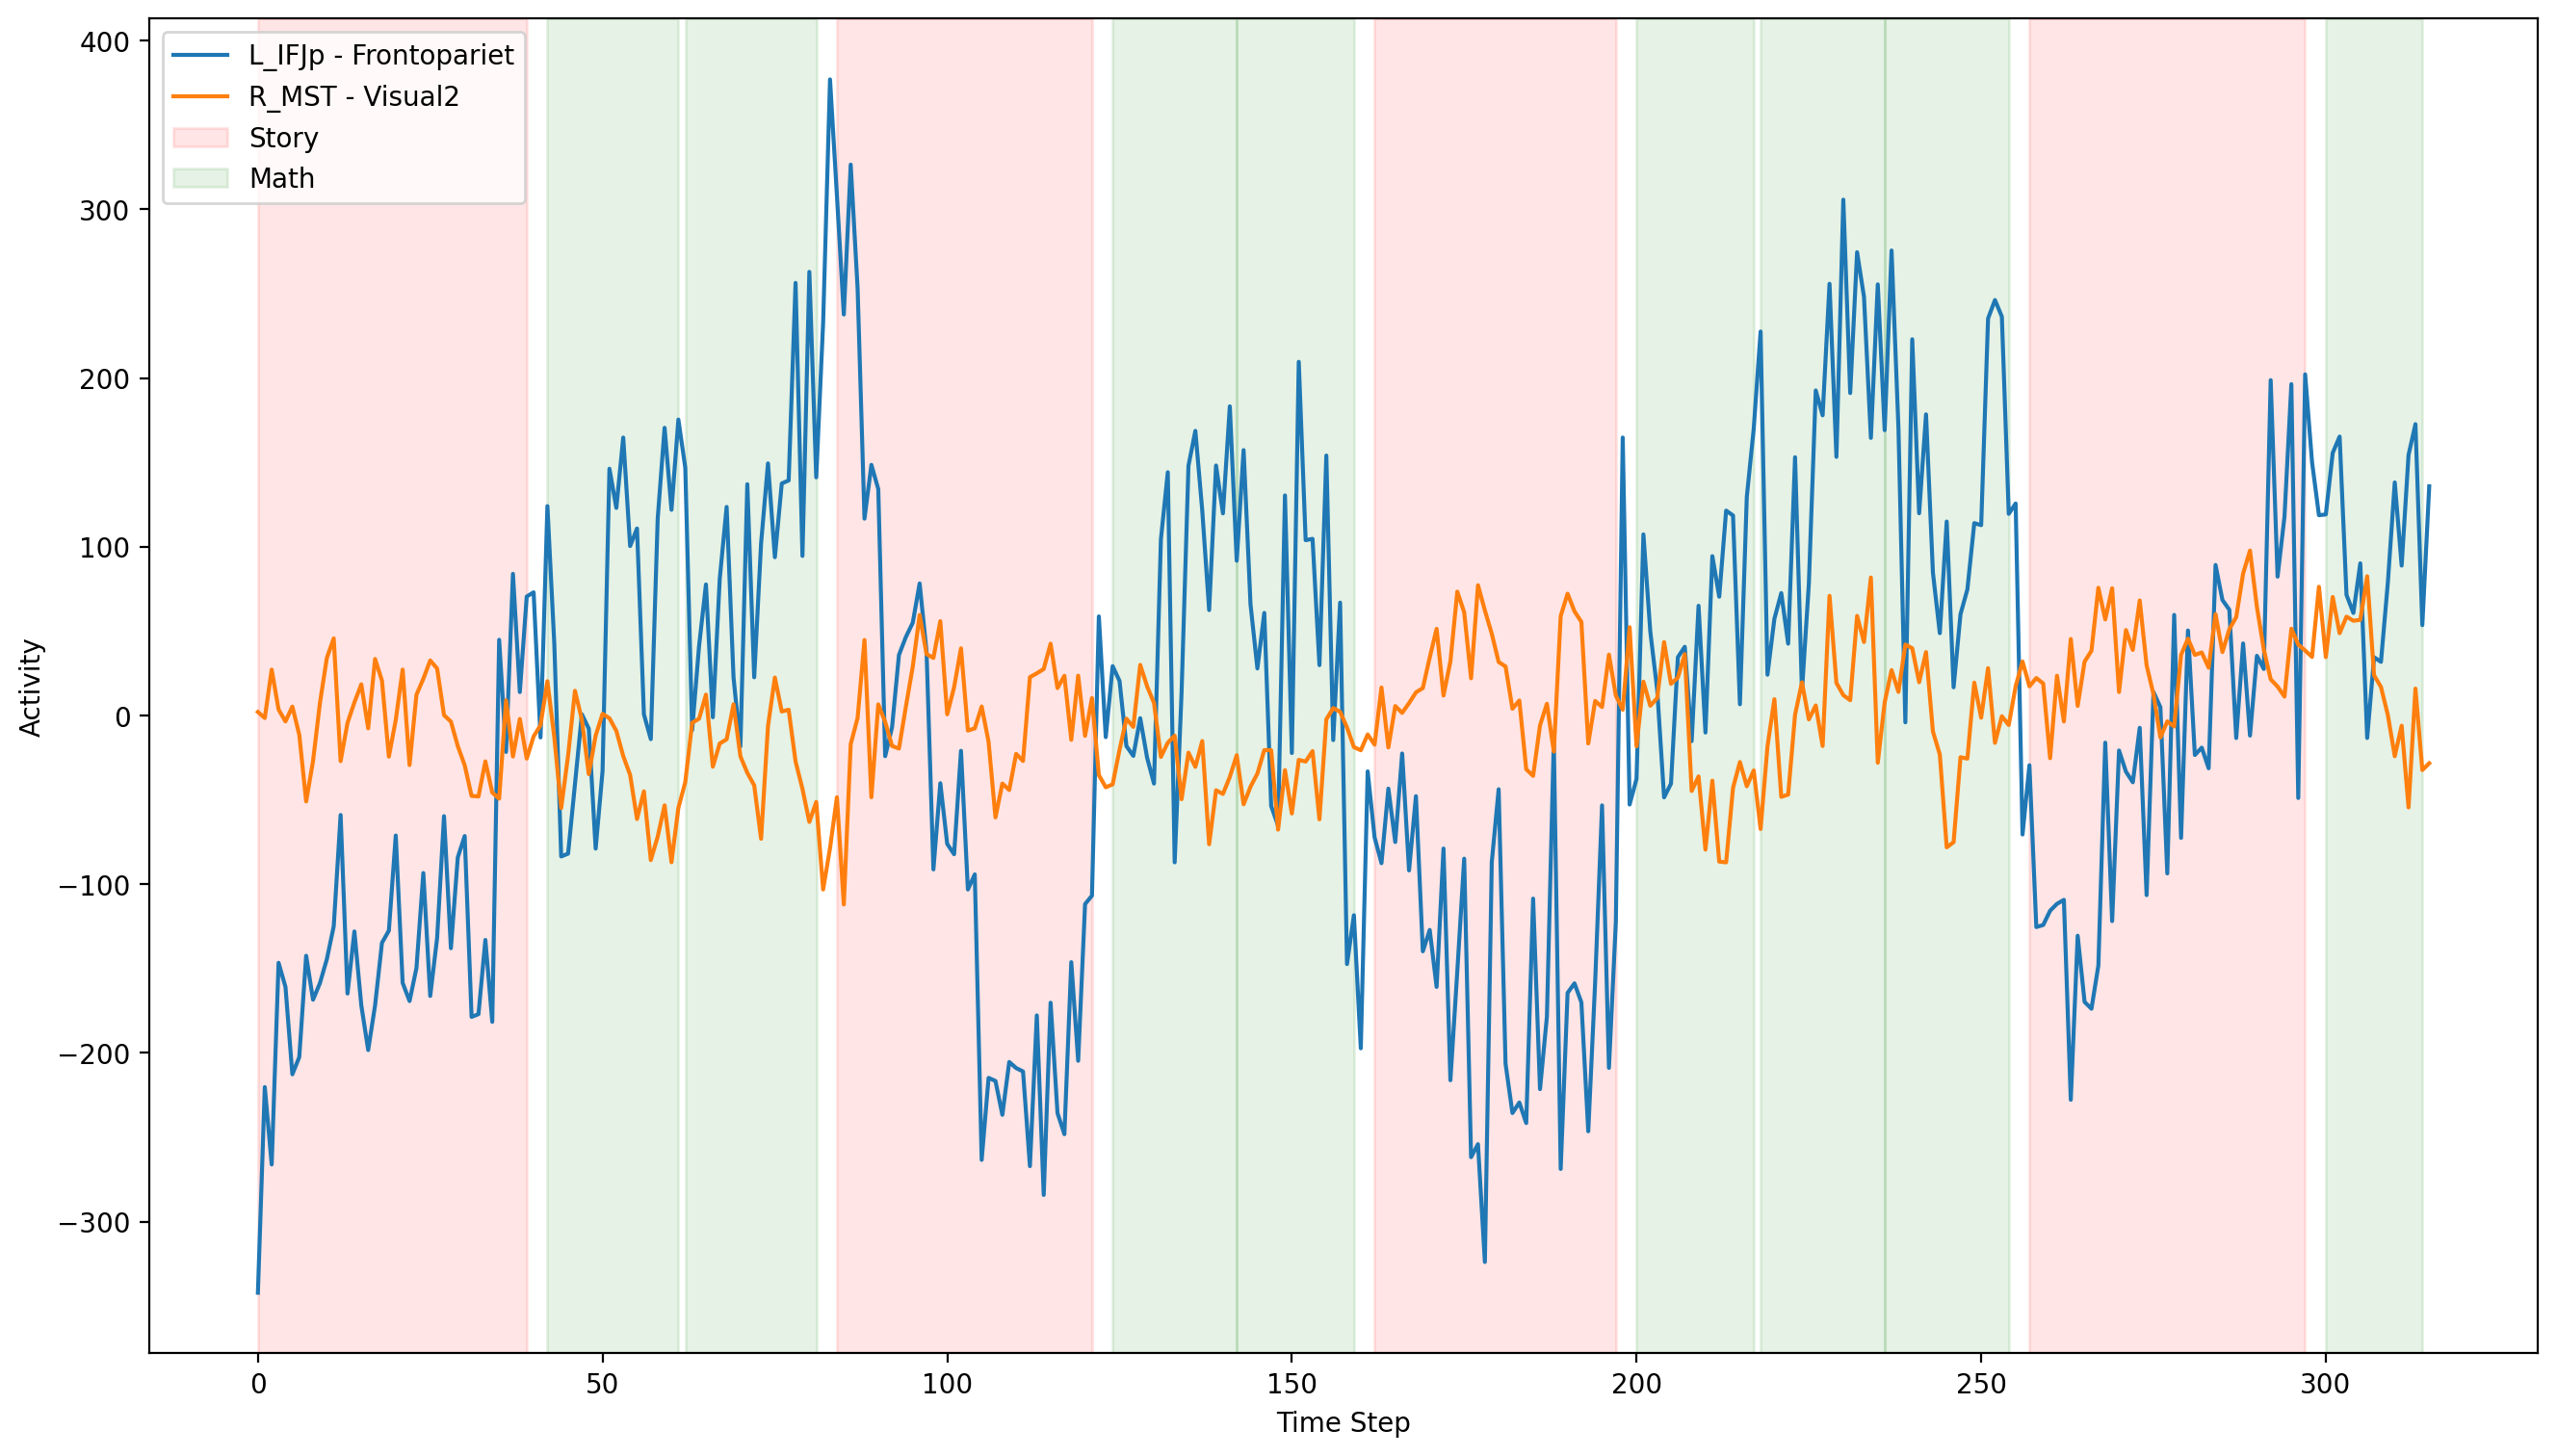

In [15]:
plt.figure(figsize=(16, 9))

plt.plot(data[259], label=f"{region_info['name'][259]} - {region_info['network'][259]}")
plt.plot(data[1], label=f"{region_info['name'][1]} - {region_info['network'][1]}")
for i, stim_idxs in enumerate(evs[1]):
    start = stim_idxs[0]
    end = stim_idxs[-1]
    if i == 0:
        plt.axvspan(start, end, color='red', alpha=0.1, label="Story")
    else:
        plt.axvspan(start, end, color='red', alpha=0.1)
        
for i, stim_idxs in enumerate(evs[0]):
    start = stim_idxs[0]
    end = stim_idxs[-1]
    
    if i == 0:
        plt.axvspan(start, end, color='green', alpha=0.1, label="Math")
    else:
        plt.axvspan(start, end, color='green', alpha=0.1)

plt.xlabel("Time Step")
plt.ylabel("Activity")
plt.legend()

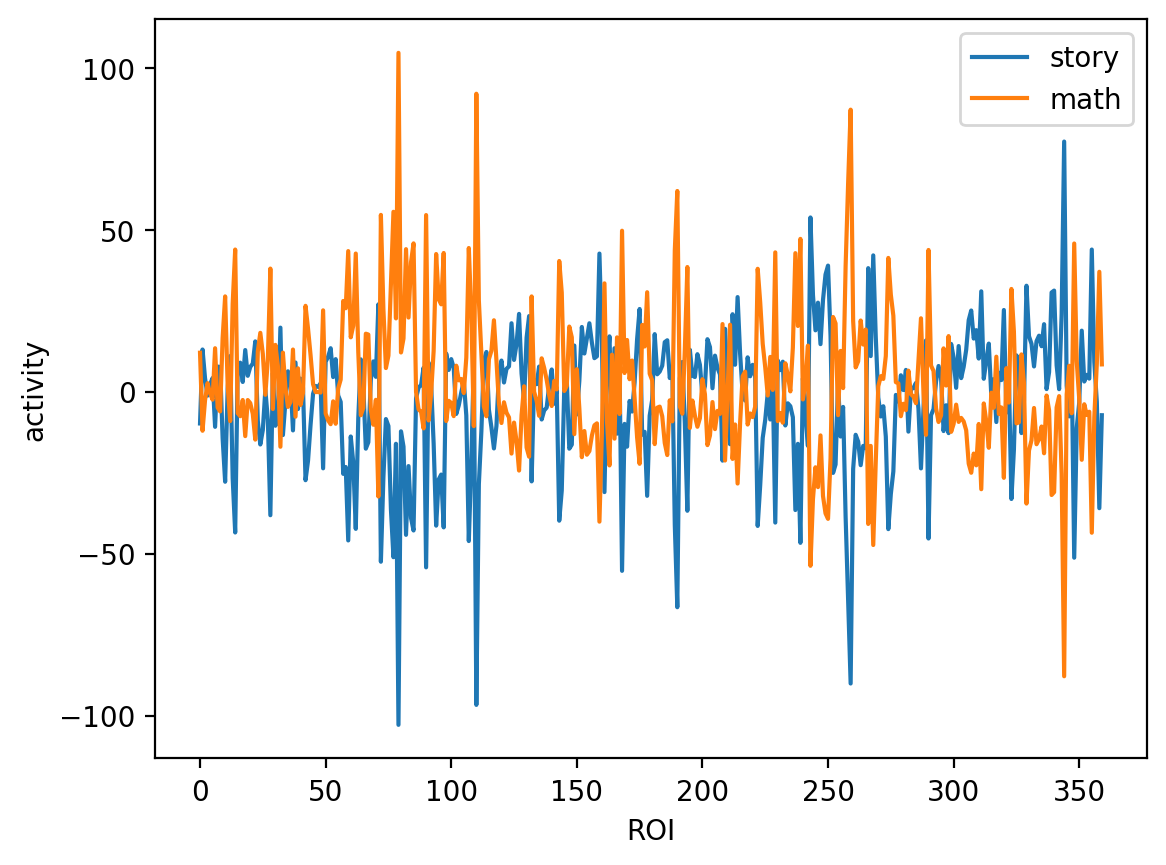

In [16]:
# we need a little function that averages all frames from any given condition
def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)


story_activity = average_frames(data, evs, my_exp, 'story')
math_activity = average_frames(data, evs, my_exp, 'math')
contrast = story_activity - math_activity  # difference between left and right hand movement
# Plot activity level in each ROI for both conditions


################ THIS IS Weired #######################


plt.plot(story_activity[:360], label='story')
plt.plot(math_activity[:360], label='math')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.show()

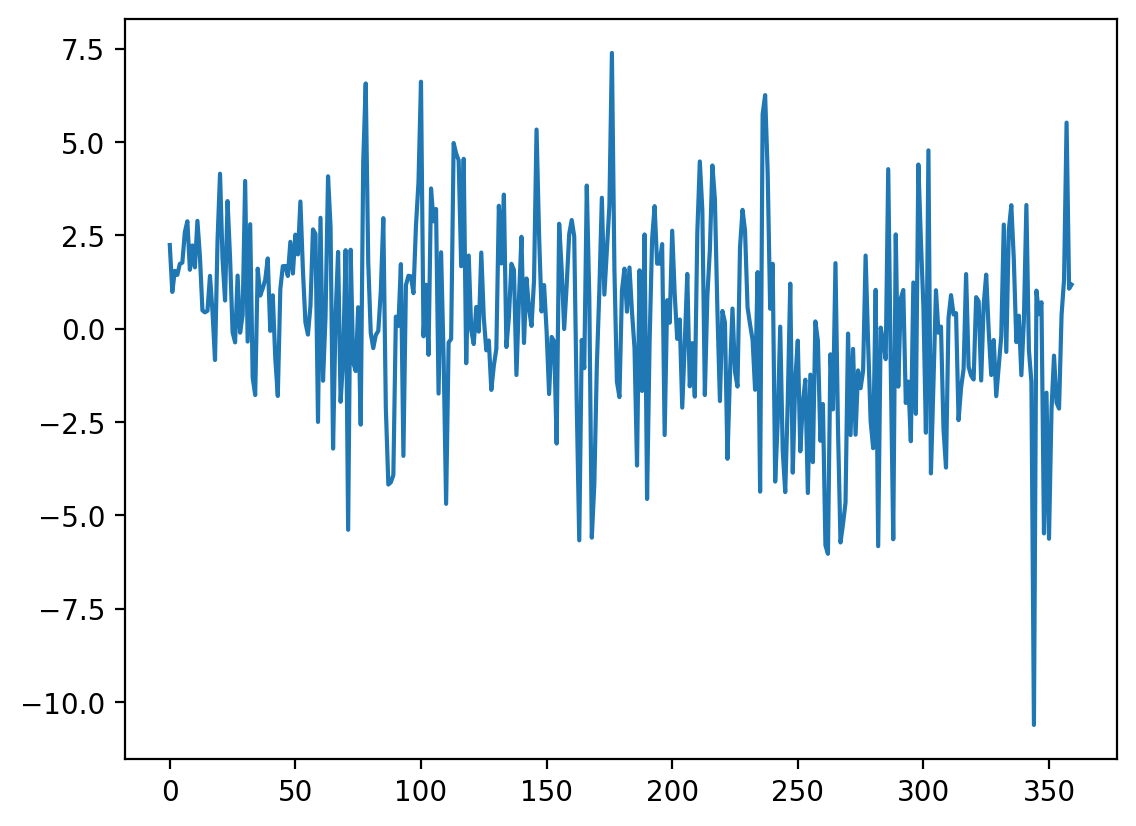

In [17]:
plt.plot(math_activity+story_activity, label='contrast')

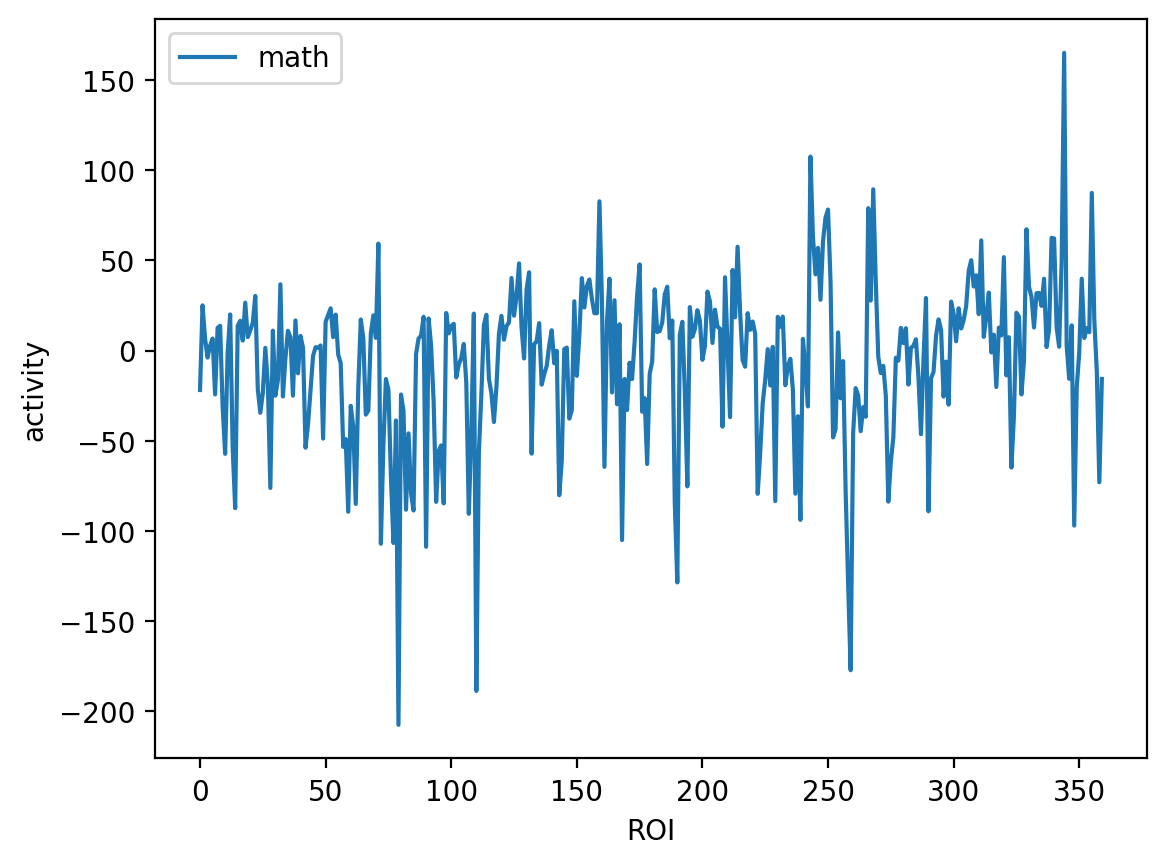

In [18]:
plt.plot(contrast, label='math')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.show()

Now let's plot these activity vectors. We will also make use of the ROI names to find out which brain areas show highest activity in these conditions. But since there are so many areas, we will group them by network.

A powerful tool for organising and plotting this data is the combination of pandas and seaborn. Below is an example where we use pandas to create a table for the activity data and we use seaborn oto visualise it.





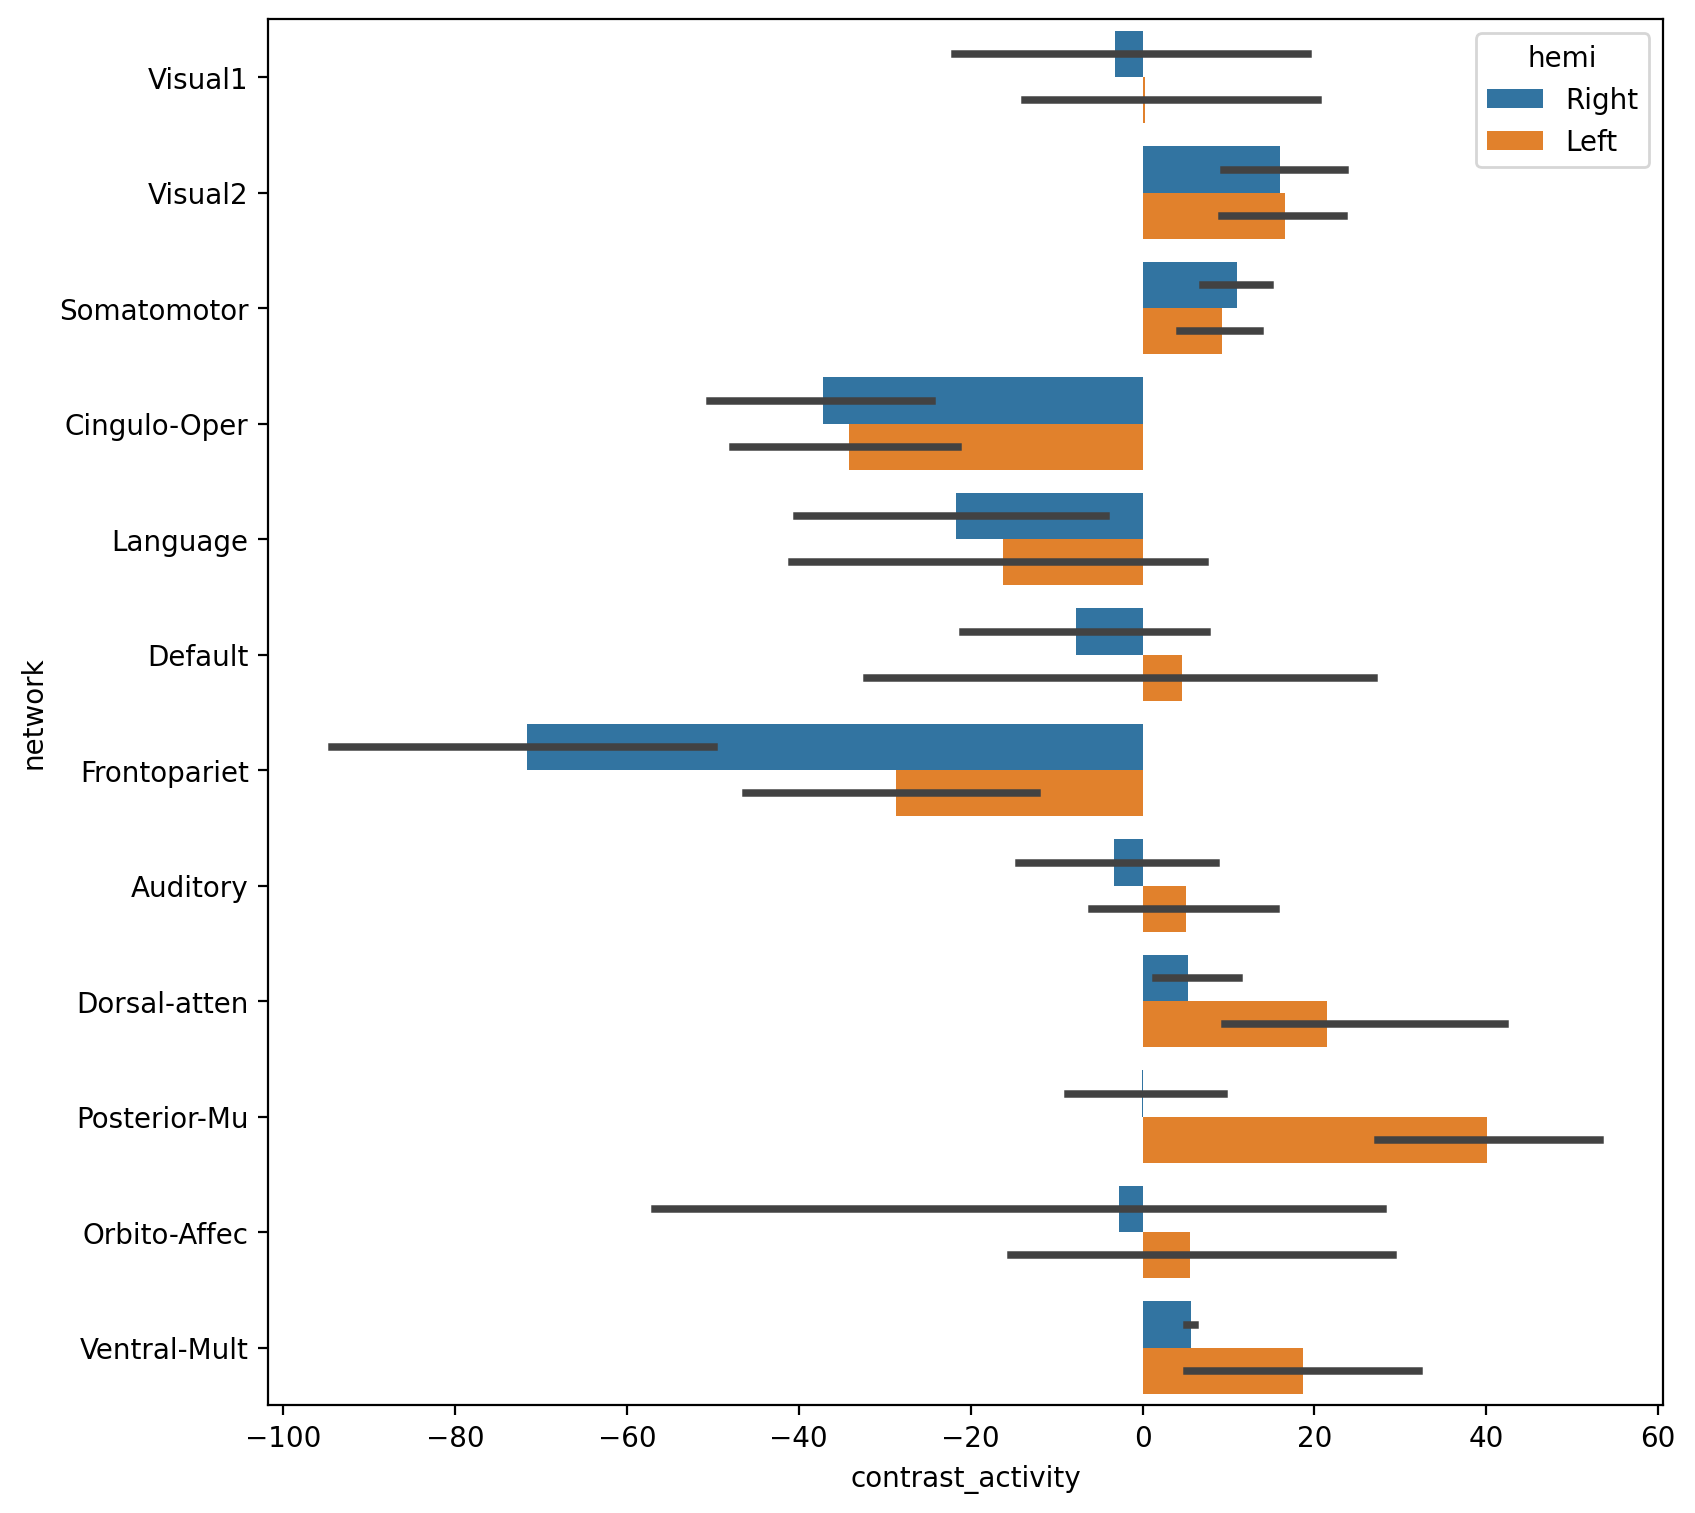

In [28]:
df = pd.DataFrame({'contrast_activity' : story_activity-math_activity,
#                    'math_activity' : math_activity,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})

fig, ax1 = plt.subplots(figsize=(9, 9))
sns.barplot(y='network', x='contrast_activity', data=df, hue='hemi',ax=ax1)
# sns.barplot(y='network', x='math_activity', data=df, hue='hemi',ax=ax2)
plt.show()

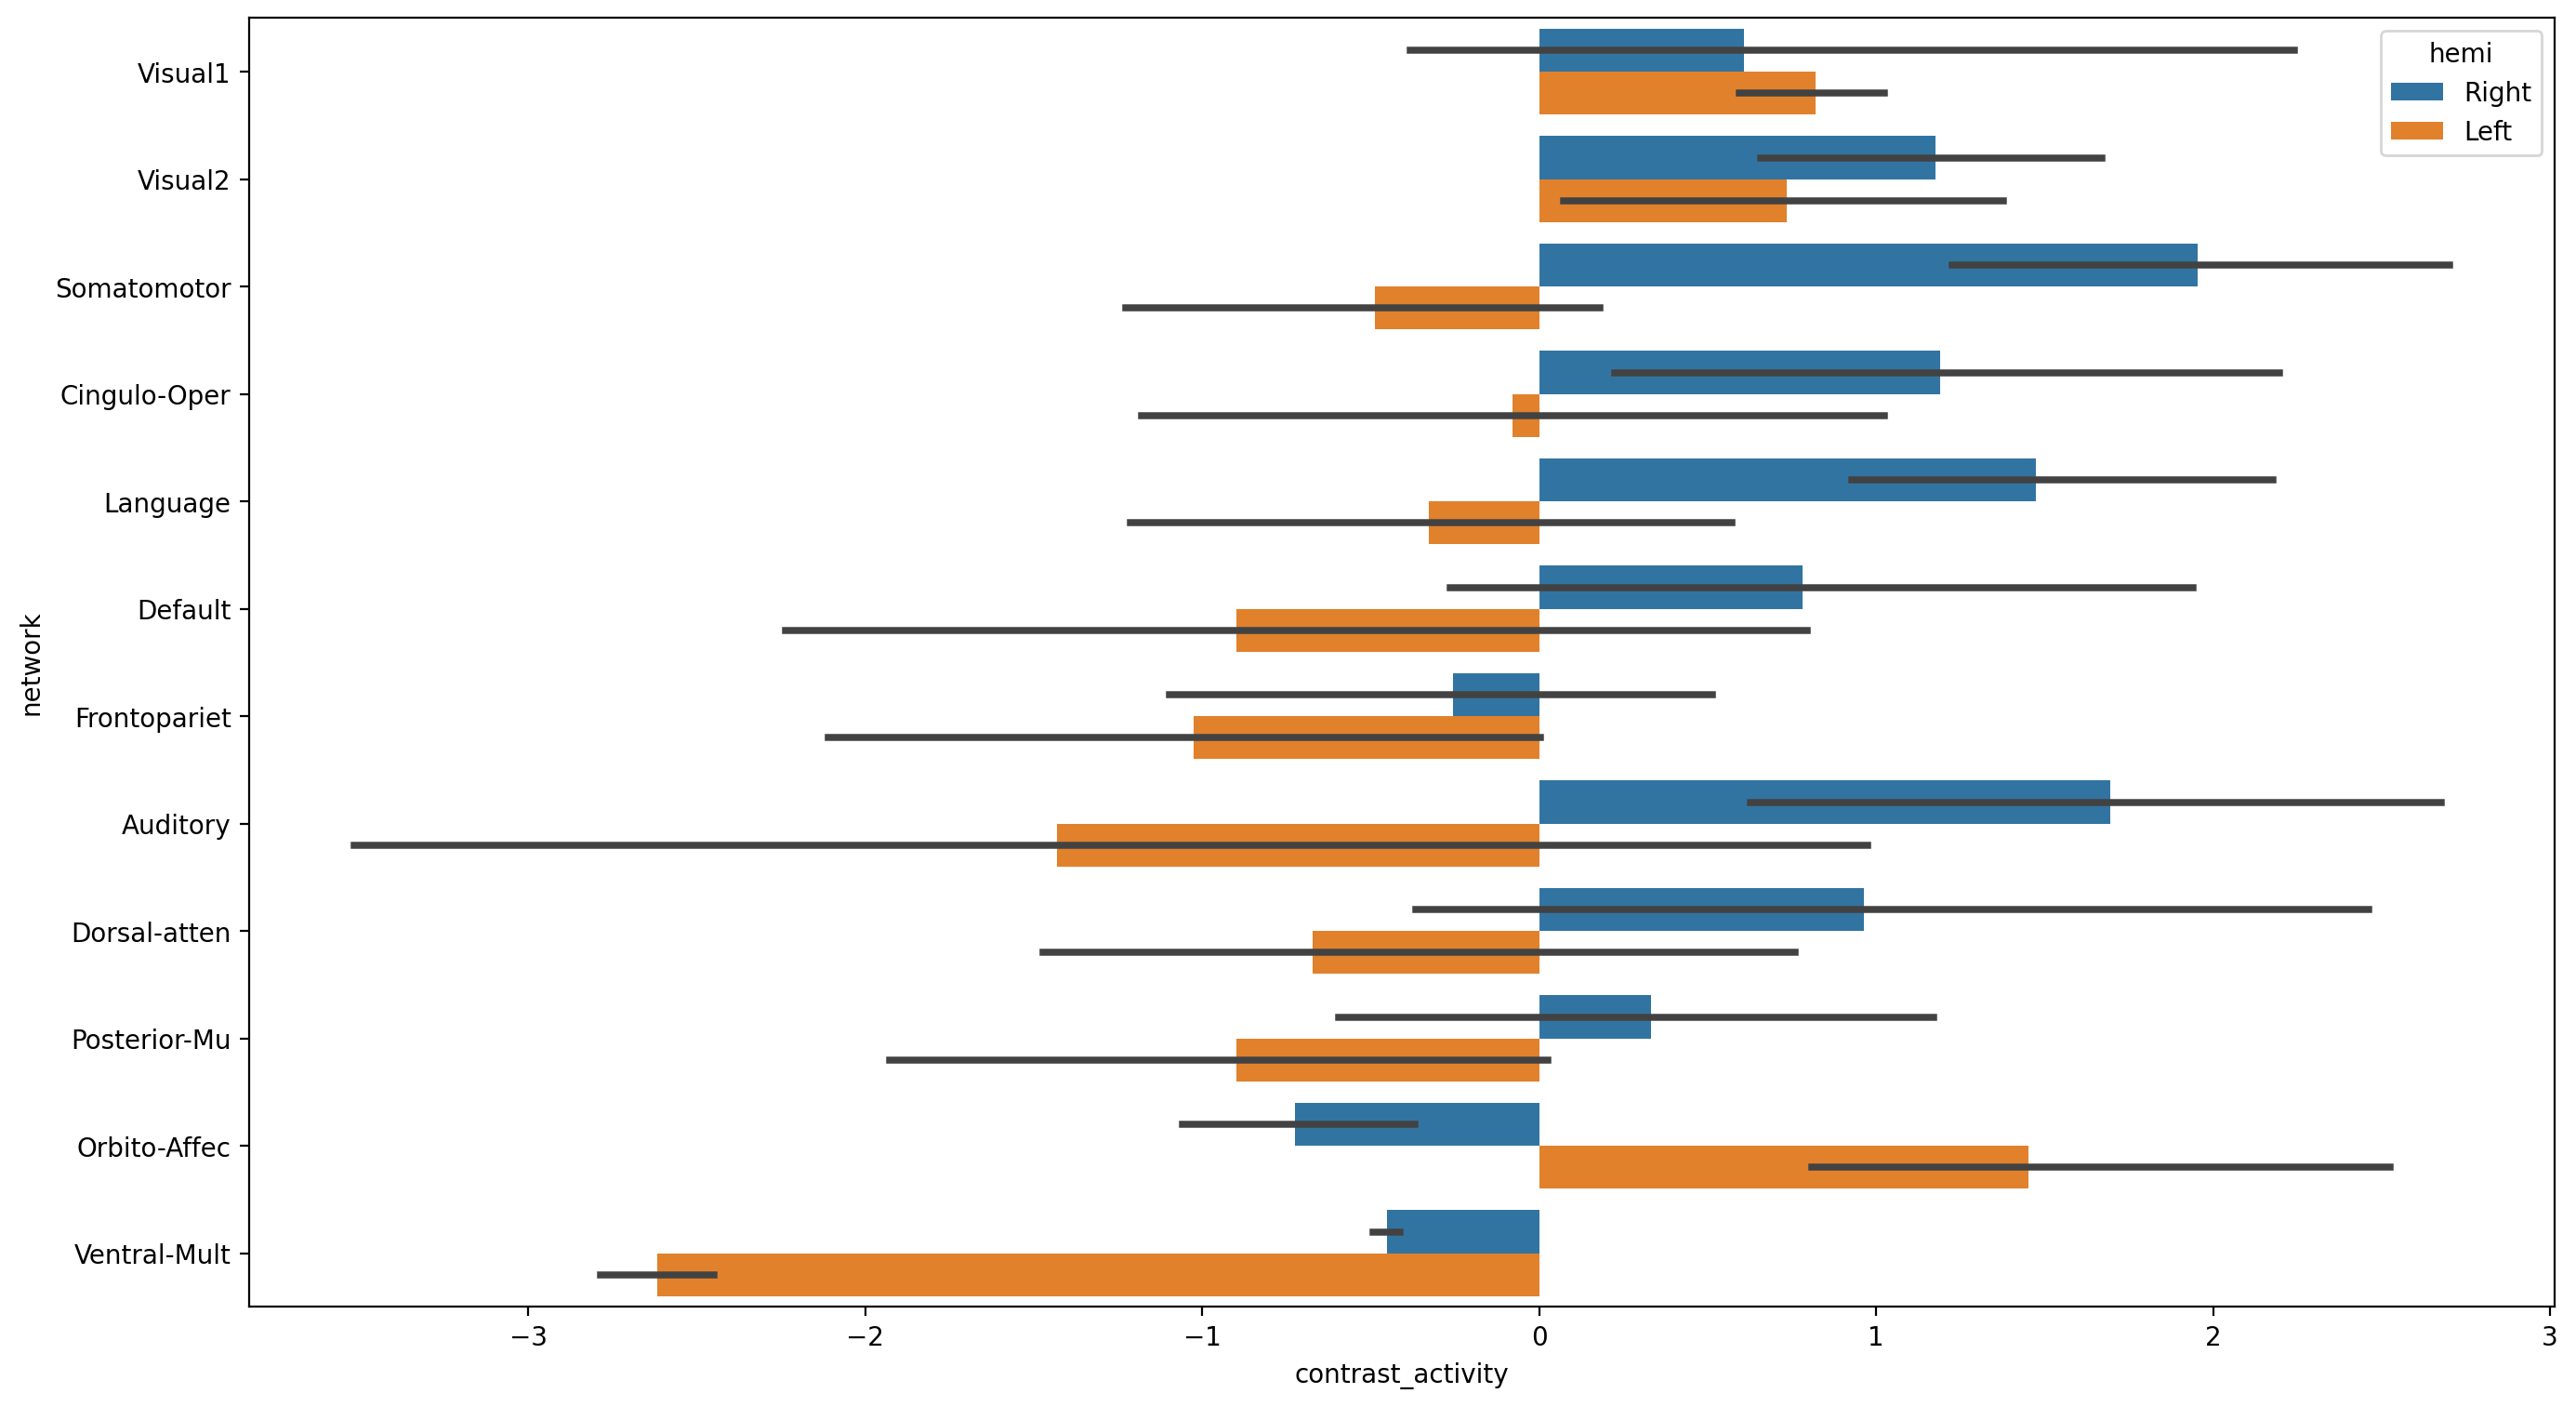

In [26]:
df = pd.DataFrame({'contrast_activity' : story_activity+math_activity,
#                    'math_activity' : math_activity,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})

fig, ax1 = plt.subplots(figsize=(16, 9))
sns.barplot(y='network', x='contrast_activity', data=df, hue='hemi',ax=ax1)
# sns.barplot(y='network', x='math_activity', data=df, hue='hemi',ax=ax2)
plt.show()

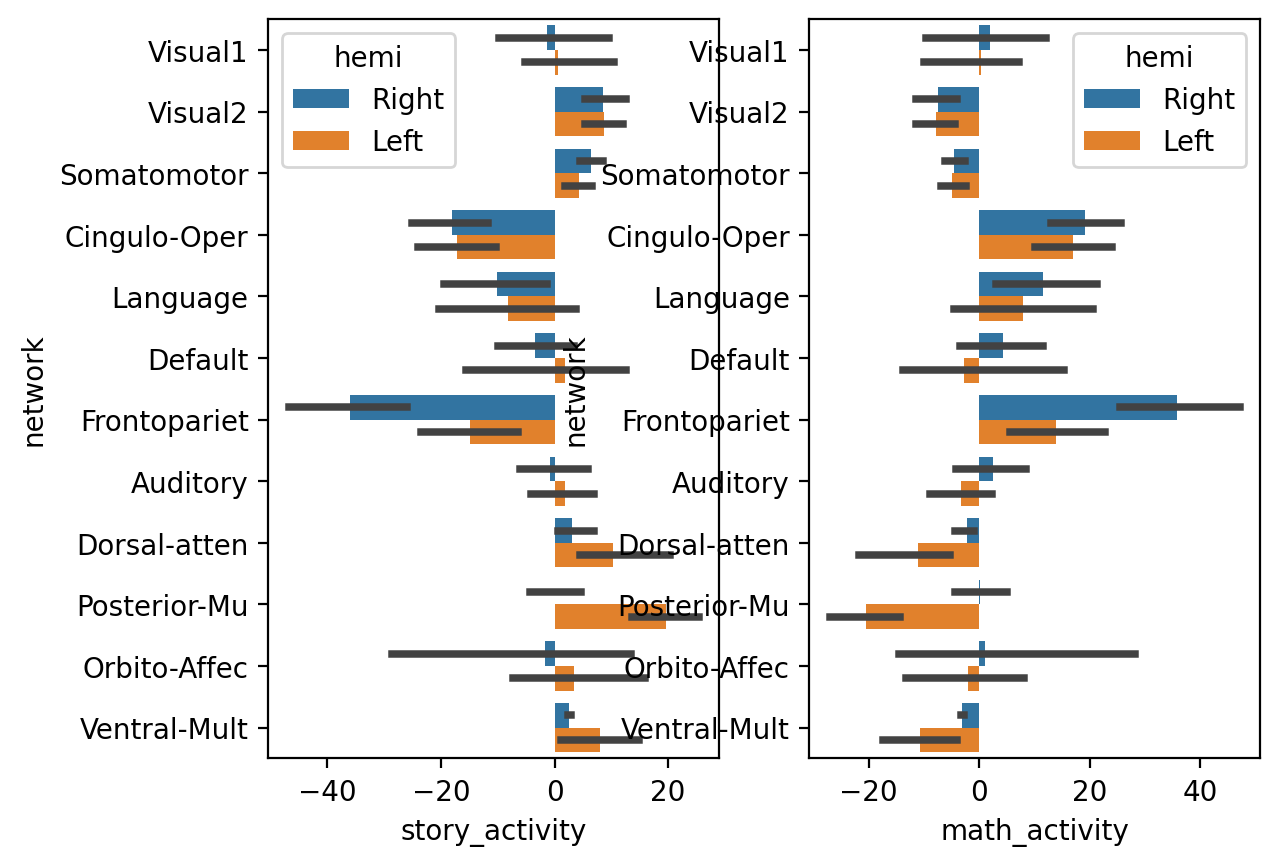

In [19]:
df = pd.DataFrame({'story_activity' : story_activity,
                   'math_activity' : math_activity,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(y='network', x='story_activity', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='math_activity', data=df, hue='hemi',ax=ax2)
plt.show()

You should be able to notice that for the somatosensory network, brain activity in the right hemi is higher for the left foot movement and vice versa for the left hemi and right foot. But this may be subtle at the single subject/session level (these are quick 3-4min scans).


Let us boost thee stats by averaging across all subjects and runs.

# Preprocess

In [20]:
# let's load everything we need to memory

stimuli_all = []
activity_all = []

for s in subjects:
    data_lr = load_single_timeseries(subject=s,
                              experiment="LANGUAGE",
                              run=0,
                              remove_mean=True)

    
    data_rl = load_single_timeseries(subject=s,
                              experiment="LANGUAGE",
                              run=1,
                              remove_mean=True)
    
    activity_all.append(
        np.vstack([data_lr, data_rl])
    )
    
    stimuli_all.append(
        mask_extracted_L(s)["math"]
    )


In [21]:
stimuli_all = np.array(stimuli_all)
activity_all = np.array(activity_all)

stimuli_all.shape, activity_all.shape

((100, 316), (100, 720, 316))

# Model and Training

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, channel_num):
        super().__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(channel_num, channel_num, 3, padding="same"),
            nn.BatchNorm1d(channel_num),
            nn.ReLU(),
        ) 
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(channel_num, channel_num, 3, padding="same"),
            nn.BatchNorm1d(channel_num),
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        
        residual = x
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x + residual
        out = self.relu(x)
        return out
    
class Stage(nn.Module):
    def __init__(self, channel_in, channel_out):
        super().__init__()
        
        self.res_block1 = ResidualBlock(channel_in)
        self.conv = nn.Conv1d(
            channel_in ,channel_out, kernel_size = 5, stride = 1, padding="same"
        )
        self.res_block2 = ResidualBlock(channel_out)
        self.pool = nn.MaxPool1d(2, 2)
        self.model_ = nn.Sequential(
            self.res_block1,
            nn.Dropout(p=0.3),
            nn.ReLU(),
            self.conv,
            nn.Dropout(p=0.3),
            nn.ReLU(),
            self.res_block2,
            nn.Dropout(p=0.3),
            nn.ReLU(),
            self.pool
        )
            

    def forward(self, x):
        return self.model_(x)

        
class ModelClassification(nn.Module):
    def __init__(self, in_channel, window_size):
        super().__init__()
        self.network = nn.Sequential(
            
#             ResidualBlock(in_channel),
#             nn.Conv1d(in_channel, 500, kernel_size = 5, stride = 1, padding="same"),
#             nn.ReLU(),
#             nn.MaxPool1d(2,2),
            Stage(in_channel, 512),
        
#             ResidualBlock(500),
#             nn.Dropout(p=0.4),
#             nn.Conv1d(500 ,300, kernel_size = 5, stride = 1, padding="same"),
#             nn.ReLU(),
#             nn.MaxPool1d(2,2),
            Stage(512, 256),
            
#             ResidualBlock(300),
#             nn.Dropout(p=0.4),
#             nn.Conv1d(300,256, kernel_size = 5, stride = 1, padding="same"),
#             nn.ReLU(),
#             nn.MaxPool1d(2,2),
            
            nn.Flatten(),
            
            nn.Linear(256 * (window_size // 4), 512), 
            nn.Dropout(p=0.4),
            nn.ReLU(),
            
#             nn.Linear(1024, 512),
#             nn.Dropout(p=0.4),
#             nn.ReLU(),
            
#             nn.Linear(512,256),
#             nn.Dropout(p=0.4),
#             nn.ReLU(),
            
            nn.Linear(512,64),
            nn.ReLU(),
            
            nn.Linear(64,1),
        )
    
    def forward(self, X):
        return self.network(X)

In [23]:
# training params
epochs = 50
window_size = 20
ROIs = np.arange(360)
batch_size = 40
training_set_size = 80
lr = 0.0001

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ModelClassification(len(ROIs)*2, window_size)
net.to(device);

In [24]:
# shuffling dataset
idxs = np.arange(len(subjects))

np.random.shuffle(idxs)

activity_all, stimuli_all = activity_all[idxs], stimuli_all[idxs]
idxs_train, idxs_val = idxs[:training_set_size], idxs[training_set_size:]


# Train-val split
X_train, st_train = activity_all[idxs_train], stimuli_all[idxs_train]
X_val, st_val = activity_all[idxs_val], stimuli_all[idxs_val]

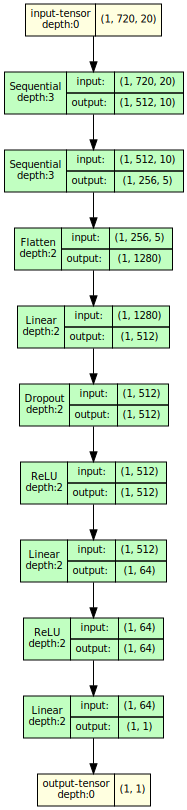

In [25]:
model_graph = draw_graph(net, input_size=(1, len(ROIs)*2, window_size))
model_graph.resize_graph(scale=5.0) 
model_graph.visual_graph.render(format='svg')
model_graph.visual_graph

In [26]:
df_subjects = pd.read_csv("./metadata_subject.csv", index_col="Subject")
columns_to_keep = {
    "Release", "Gender", "Age", "Language_Task_Acc", 
    "Language_Task_Story_Acc", "Language_Task_Story_Avg_Difficulty_Level",
    "Language_Task_Math_Acc", "Language_Task_Math_Avg_Difficulty_Level",
}
for col in df_subjects.columns:
    if col not in columns_to_keep:
        df_subjects = df_subjects.drop(col, axis=1)
df_subjects.head(3)

,Release,Gender,Age,Language_Task_Acc,Language_Task_Story_Acc,Language_Task_Story_Avg_Difficulty_Level,Language_Task_Math_Acc,Language_Task_Math_Avg_Difficulty_Level
Subject,,,,,,,,
100004,S900,M,22-25,NaN,NaN,NaN,NaN,NaN
100206,S900,M,26-30,96.875,100.0,9.071,93.750,1.964
100307,Q1,F,26-30,80.417,87.5,9.607,73.333,2.893


In [27]:
def extract_stimuli_data(X_val, idxs_val, window_size, df_subjects):
    all_X_val = []
    all_y_val = []
    dict_md = {key:[] for key in df_subjects.columns}
    # i = 0            
    for i in range(len(idxs_val)):

        index = idxs_val[i] 
        math_ts, story_ts = load_evs(subjects[index], "LANGUAGE", 0)
        for stim in math_ts:
            try:
                all_X_val.append(X_val[i][:, stim[0] : stim[0] + window_size])
                all_y_val.append(1)
                
                for key in df_subjects.columns:
                    dict_md[key].append(df_subjects.loc[int(subjects[index])][key])
            except IndexError:
                pass
            
        if all_X_val[-1].shape[1] < window_size:
            all_X_val.pop()
            all_y_val.pop()
            for key in df_subjects.columns:
                dict_md[key].pop()

        for stim in story_ts:
            try:
                all_X_val.append(X_val[i][:, stim[0] : stim[0] + window_size])
                all_y_val.append(0)
                
                for key in df_subjects.columns:
                    dict_md[key].append(df_subjects.loc[int(subjects[index])][key])
            except IndexError:
                pass
        if all_X_val[-1].shape[1] < window_size:
            all_X_val.pop()
            all_y_val.pop()
            for key in df_subjects.columns:
                dict_md[key].pop()
    return np.array(all_X_val), np.array(all_y_val).reshape((-1, 1)), dict_md

In [28]:
X_val_stim, y_val_stim, dict_md_val = extract_stimuli_data(X_val, idxs_val, window_size, df_subjects)

In [29]:
def accuracy(X, y, net, is_numpy=False):
    net.eval()
    if is_numpy:
        X = torch.from_numpy(X).to(device=device).float()
        y = torch.from_numpy(y).to(device=device).float()
    out = net(X)
    out = out.cpu().detach().numpy() >= 0
    y = y.cpu().detach().numpy() >= 0.5
    if y.shape != out.shape:
        y = y.reshape((-1, 1))
        out = out.reshape((-1, 1))
        
    acc_ = (out == y).astype(np.int16).mean().copy()
    del out
    return acc_

def preprocess_batch(start, ibatch, X_, st_, window_size, regions):
    set_size = len(X_)
    itime = np.arange(start, start + window_size)
    s_inxds = np.arange(ibatch, min(set_size, ibatch + batch_size))
    
    X_batch = X_      [s_inxds, :, :]
    X_batch = X_batch[:, regions, :]
    X_batch = X_batch[:, :, itime]

    st_batch = st_     [s_inxds, :]
    st_batch = st_batch[:, itime]

    y_batch = np.mean(st_batch, axis=1, keepdims=True)
    return X_batch, y_batch

def train_batch(net, loss_fn, ibatch, X_train, st_train, window_size, regions, batch_size, optimizer):
    
    starting_indexes = np.arange(
        np.random.randint(0, window_size-1), 316-window_size, window_size
    ) 
    
    np.random.shuffle(starting_indexes)
    loss_avg = []
    acc_avg = []
    for start in starting_indexes:
        X_train_batch, y_train_batch = preprocess_batch(start, ibatch, X_train, st_train, window_size, regions)

        X_train_batch = torch.from_numpy(X_train_batch).to(device=device).float()
        y_train_batch = torch.from_numpy(y_train_batch).to(device=device).float()

        optimizer.zero_grad()
        out = net(X_train_batch)
        loss = loss_fn(out, y_train_batch)
        loss.backward()
        optimizer.step()
        loss_avg.append(loss.detach().cpu().numpy())
        acc = accuracy(X_train_batch, y_train_batch, net)
        acc_avg.append(acc)
             
    return np.array(loss_avg).mean(), np.array(acc_avg).mean()

def evaluate_model(net, X, y, ROIs):
    net.eval()
    regions = np.hstack([ROIs, ROIs+360])
    loss_fn = nn.BCEWithLogitsLoss()
    
    with torch.no_grad():
        X = X[:, regions, :]
        X = torch.from_numpy(X).to(device=device).float()
        y = torch.from_numpy(y).to(device=device).float()

        out = net(X)

        loss_epoch = loss_fn(out, y)
        acc_epoch = accuracy(X, y, net)
        del out, X, y
    
    return loss_epoch, acc_epoch

In [30]:
def train(net, epochs, X_train, st_train, X_val, y_val, window_size, ROIs, batch_size, lr):
    net.train()
    regions = np.hstack([ROIs, ROIs+360])

    history = {
        "train_loss" : [],
        "val_loss" : [],
        "train_acc" : [],
        "val_acc" : [],
    }
    optimizer = torch.optim.Adam(net.parameters(), lr, weight_decay=1e-4)
    loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        net.train()
        batch_losses = []
        batch_accs = []
        
        ########################## Training ##########################
        with tqdm(total=training_set_size) as pbar:
            for ibatch in np.arange(0, training_set_size, batch_size):
                
                loss_batch, acc_batch = train_batch(net, loss_fn, ibatch, X_train, st_train, window_size, regions, batch_size, optimizer)
                pbar.update(
                    min(training_set_size - ibatch, batch_size)
                )
                batch_losses.append(loss_batch)
                batch_accs.append(acc_batch)
        loss_epoch = np.array(batch_losses).mean()
        acc_epoch = np.array(batch_accs).mean()
        print(f"Epoch {epoch}:")
        print(f"Training: Loss={loss_epoch} - Accuracy={acc_epoch}")   
        history["train_loss"].append(loss_epoch)
        history["train_acc"].append(acc_epoch)
        
        
        ########################## Validation ##########################        
        loss_epoch, acc_epoch = evaluate_model(net, X_val, y_val, ROIs)

        print(f"Validation: Loss={loss_epoch} - Accuracy={acc_epoch}")   
        history["val_loss"].append(loss_epoch.cpu().numpy())
        history["val_acc"].append(acc_epoch)

        
    return history

In [31]:
history = train(net, epochs, X_train, st_train, X_val_stim, y_val_stim, window_size, ROIs, batch_size, lr)

100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 16.94it/s]


Epoch 0:
Training: Loss=0.8668482303619385 - Accuracy=0.6058333333333332
Validation: Loss=0.6148731112480164 - Accuracy=0.6694560669456067


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.09it/s]


Epoch 1:
Training: Loss=0.619262158870697 - Accuracy=0.6841666666666666
Validation: Loss=0.5550576448440552 - Accuracy=0.7196652719665272


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 19.25it/s]


Epoch 2:
Training: Loss=0.5572267770767212 - Accuracy=0.8316666666666666
Validation: Loss=0.4772707521915436 - Accuracy=0.7907949790794979


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.66it/s]


Epoch 3:
Training: Loss=0.46069252490997314 - Accuracy=0.8791666666666667
Validation: Loss=0.52622389793396 - Accuracy=0.7573221757322176


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.39it/s]


Epoch 4:
Training: Loss=0.42674577236175537 - Accuracy=0.8808333333333334
Validation: Loss=0.3883890211582184 - Accuracy=0.8535564853556485


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 19.15it/s]


Epoch 5:
Training: Loss=0.37194669246673584 - Accuracy=0.9145833333333333
Validation: Loss=0.38011136651039124 - Accuracy=0.8619246861924686


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.47it/s]


Epoch 6:
Training: Loss=0.35288578271865845 - Accuracy=0.9341666666666667
Validation: Loss=0.4430076479911804 - Accuracy=0.8661087866108786


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 17.84it/s]


Epoch 7:
Training: Loss=0.32557427883148193 - Accuracy=0.9241666666666666
Validation: Loss=0.3774968683719635 - Accuracy=0.8577405857740585


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 17.81it/s]


Epoch 8:
Training: Loss=0.3228645324707031 - Accuracy=0.9391666666666666
Validation: Loss=0.3768625557422638 - Accuracy=0.8702928870292888


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 16.67it/s]


Epoch 9:
Training: Loss=0.33703815937042236 - Accuracy=0.9433333333333332
Validation: Loss=0.504257082939148 - Accuracy=0.8410041841004184


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 17.64it/s]


Epoch 10:
Training: Loss=0.337545782327652 - Accuracy=0.9324999999999999
Validation: Loss=0.42497825622558594 - Accuracy=0.8702928870292888


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.70it/s]


Epoch 11:
Training: Loss=0.30132174491882324 - Accuracy=0.9602976190476189
Validation: Loss=0.4036632180213928 - Accuracy=0.8661087866108786


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 17.34it/s]


Epoch 12:
Training: Loss=0.32835036516189575 - Accuracy=0.9375
Validation: Loss=0.5263512134552002 - Accuracy=0.8284518828451883


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.18it/s]


Epoch 13:
Training: Loss=0.3267517387866974 - Accuracy=0.9474999999999999
Validation: Loss=0.4137701988220215 - Accuracy=0.8661087866108786


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 16.97it/s]


Epoch 14:
Training: Loss=0.3090056777000427 - Accuracy=0.9491666666666666
Validation: Loss=0.4064491093158722 - Accuracy=0.8786610878661087


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 19.00it/s]


Epoch 15:
Training: Loss=0.2763569951057434 - Accuracy=0.969642857142857
Validation: Loss=0.3935107886791229 - Accuracy=0.8661087866108786


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 16.58it/s]


Epoch 16:
Training: Loss=0.3005307912826538 - Accuracy=0.9641666666666667
Validation: Loss=0.3827647864818573 - Accuracy=0.8744769874476988


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 17.80it/s]


Epoch 17:
Training: Loss=0.3144242763519287 - Accuracy=0.9458333333333333
Validation: Loss=0.40736687183380127 - Accuracy=0.8619246861924686


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.66it/s]


Epoch 18:
Training: Loss=0.2952442169189453 - Accuracy=0.9582142857142857
Validation: Loss=0.4781918525695801 - Accuracy=0.8410041841004184


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 17.66it/s]


Epoch 19:
Training: Loss=0.2974282205104828 - Accuracy=0.9633333333333332
Validation: Loss=0.4614464044570923 - Accuracy=0.8410041841004184


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 16.60it/s]


Epoch 20:
Training: Loss=0.2952383756637573 - Accuracy=0.9591666666666667
Validation: Loss=0.35731714963912964 - Accuracy=0.8661087866108786


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.19it/s]


Epoch 21:
Training: Loss=0.29660308361053467 - Accuracy=0.9576785714285714
Validation: Loss=0.4653738737106323 - Accuracy=0.8451882845188284


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 17.68it/s]


Epoch 22:
Training: Loss=0.32852286100387573 - Accuracy=0.9199999999999999
Validation: Loss=0.3952547311782837 - Accuracy=0.8619246861924686


100%|██████████████████████████████████████████████| 80/80 [00:05<00:00, 15.26it/s]


Epoch 23:
Training: Loss=0.3107448220252991 - Accuracy=0.9541666666666667
Validation: Loss=0.45946431159973145 - Accuracy=0.8535564853556485


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 17.51it/s]


Epoch 24:
Training: Loss=0.32698333263397217 - Accuracy=0.9392261904761905
Validation: Loss=0.46171754598617554 - Accuracy=0.8577405857740585


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.18it/s]


Epoch 25:
Training: Loss=0.3302815556526184 - Accuracy=0.9322619047619047
Validation: Loss=0.5343617796897888 - Accuracy=0.8368200836820083


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 17.16it/s]


Epoch 26:
Training: Loss=0.2970343828201294 - Accuracy=0.9724999999999999
Validation: Loss=0.40893763303756714 - Accuracy=0.8870292887029289


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 17.14it/s]


Epoch 27:
Training: Loss=0.3283292055130005 - Accuracy=0.9433333333333332
Validation: Loss=0.5431747436523438 - Accuracy=0.8242677824267782


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.02it/s]


Epoch 28:
Training: Loss=0.2880929708480835 - Accuracy=0.9608333333333332
Validation: Loss=0.42783793807029724 - Accuracy=0.8619246861924686


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.40it/s]


Epoch 29:
Training: Loss=0.26303422451019287 - Accuracy=0.9779761904761903
Validation: Loss=0.43872514367103577 - Accuracy=0.8744769874476988


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 17.56it/s]


Epoch 30:
Training: Loss=0.2913869023323059 - Accuracy=0.9533333333333334
Validation: Loss=0.4677802324295044 - Accuracy=0.8451882845188284


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.27it/s]


Epoch 31:
Training: Loss=0.2685673236846924 - Accuracy=0.9673214285714286
Validation: Loss=0.4982186257839203 - Accuracy=0.8493723849372385


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 17.48it/s]


Epoch 32:
Training: Loss=0.27200666069984436 - Accuracy=0.9616666666666667
Validation: Loss=0.4682270288467407 - Accuracy=0.8493723849372385


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 17.64it/s]


Epoch 33:
Training: Loss=0.284758985042572 - Accuracy=0.9766666666666666
Validation: Loss=0.3875806927680969 - Accuracy=0.8828451882845189


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.15it/s]


Epoch 34:
Training: Loss=0.2914940118789673 - Accuracy=0.9774999999999999
Validation: Loss=0.4187680780887604 - Accuracy=0.8744769874476988


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 17.35it/s]


Epoch 35:
Training: Loss=0.2744898796081543 - Accuracy=0.9833333333333334
Validation: Loss=0.39207202196121216 - Accuracy=0.8744769874476988


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 17.97it/s]


Epoch 36:
Training: Loss=0.2770419716835022 - Accuracy=0.9683333333333334
Validation: Loss=0.4559420049190521 - Accuracy=0.8577405857740585


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.88it/s]


Epoch 37:
Training: Loss=0.26323115825653076 - Accuracy=0.9664285714285714
Validation: Loss=0.44263654947280884 - Accuracy=0.8702928870292888


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.12it/s]


Epoch 38:
Training: Loss=0.25963300466537476 - Accuracy=0.9675
Validation: Loss=0.5580477118492126 - Accuracy=0.8284518828451883


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.89it/s]


Epoch 39:
Training: Loss=0.2714162766933441 - Accuracy=0.975654761904762
Validation: Loss=0.4216214418411255 - Accuracy=0.891213389121339


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 17.94it/s]


Epoch 40:
Training: Loss=0.24043405055999756 - Accuracy=0.9928571428571429
Validation: Loss=0.41710904240608215 - Accuracy=0.8744769874476988


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.38it/s]


Epoch 41:
Training: Loss=0.26182037591934204 - Accuracy=0.9774999999999998
Validation: Loss=0.4997859597206116 - Accuracy=0.8368200836820083


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.75it/s]


Epoch 42:
Training: Loss=0.2699097692966461 - Accuracy=0.9727380952380951
Validation: Loss=0.37085917592048645 - Accuracy=0.8744769874476988


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.24it/s]


Epoch 43:
Training: Loss=0.31000757217407227 - Accuracy=0.95
Validation: Loss=0.4432472586631775 - Accuracy=0.8828451882845189


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.67it/s]


Epoch 44:
Training: Loss=0.2636619806289673 - Accuracy=0.9635714285714285
Validation: Loss=0.4808240830898285 - Accuracy=0.8619246861924686


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.08it/s]


Epoch 45:
Training: Loss=0.29097092151641846 - Accuracy=0.9524999999999999
Validation: Loss=0.4180968105792999 - Accuracy=0.8661087866108786


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.14it/s]


Epoch 46:
Training: Loss=0.2906240224838257 - Accuracy=0.9624999999999999
Validation: Loss=0.45766323804855347 - Accuracy=0.8744769874476988


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 17.16it/s]


Epoch 47:
Training: Loss=0.27672284841537476 - Accuracy=0.9741666666666666
Validation: Loss=0.44073376059532166 - Accuracy=0.8702928870292888


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.30it/s]


Epoch 48:
Training: Loss=0.2653769850730896 - Accuracy=0.9633333333333333
Validation: Loss=0.38646775484085083 - Accuracy=0.8786610878661087


100%|██████████████████████████████████████████████| 80/80 [00:04<00:00, 18.05it/s]

Epoch 49:
Training: Loss=0.28166115283966064 - Accuracy=0.9466666666666667
Validation: Loss=0.4085545837879181 - Accuracy=0.8744769874476988


''

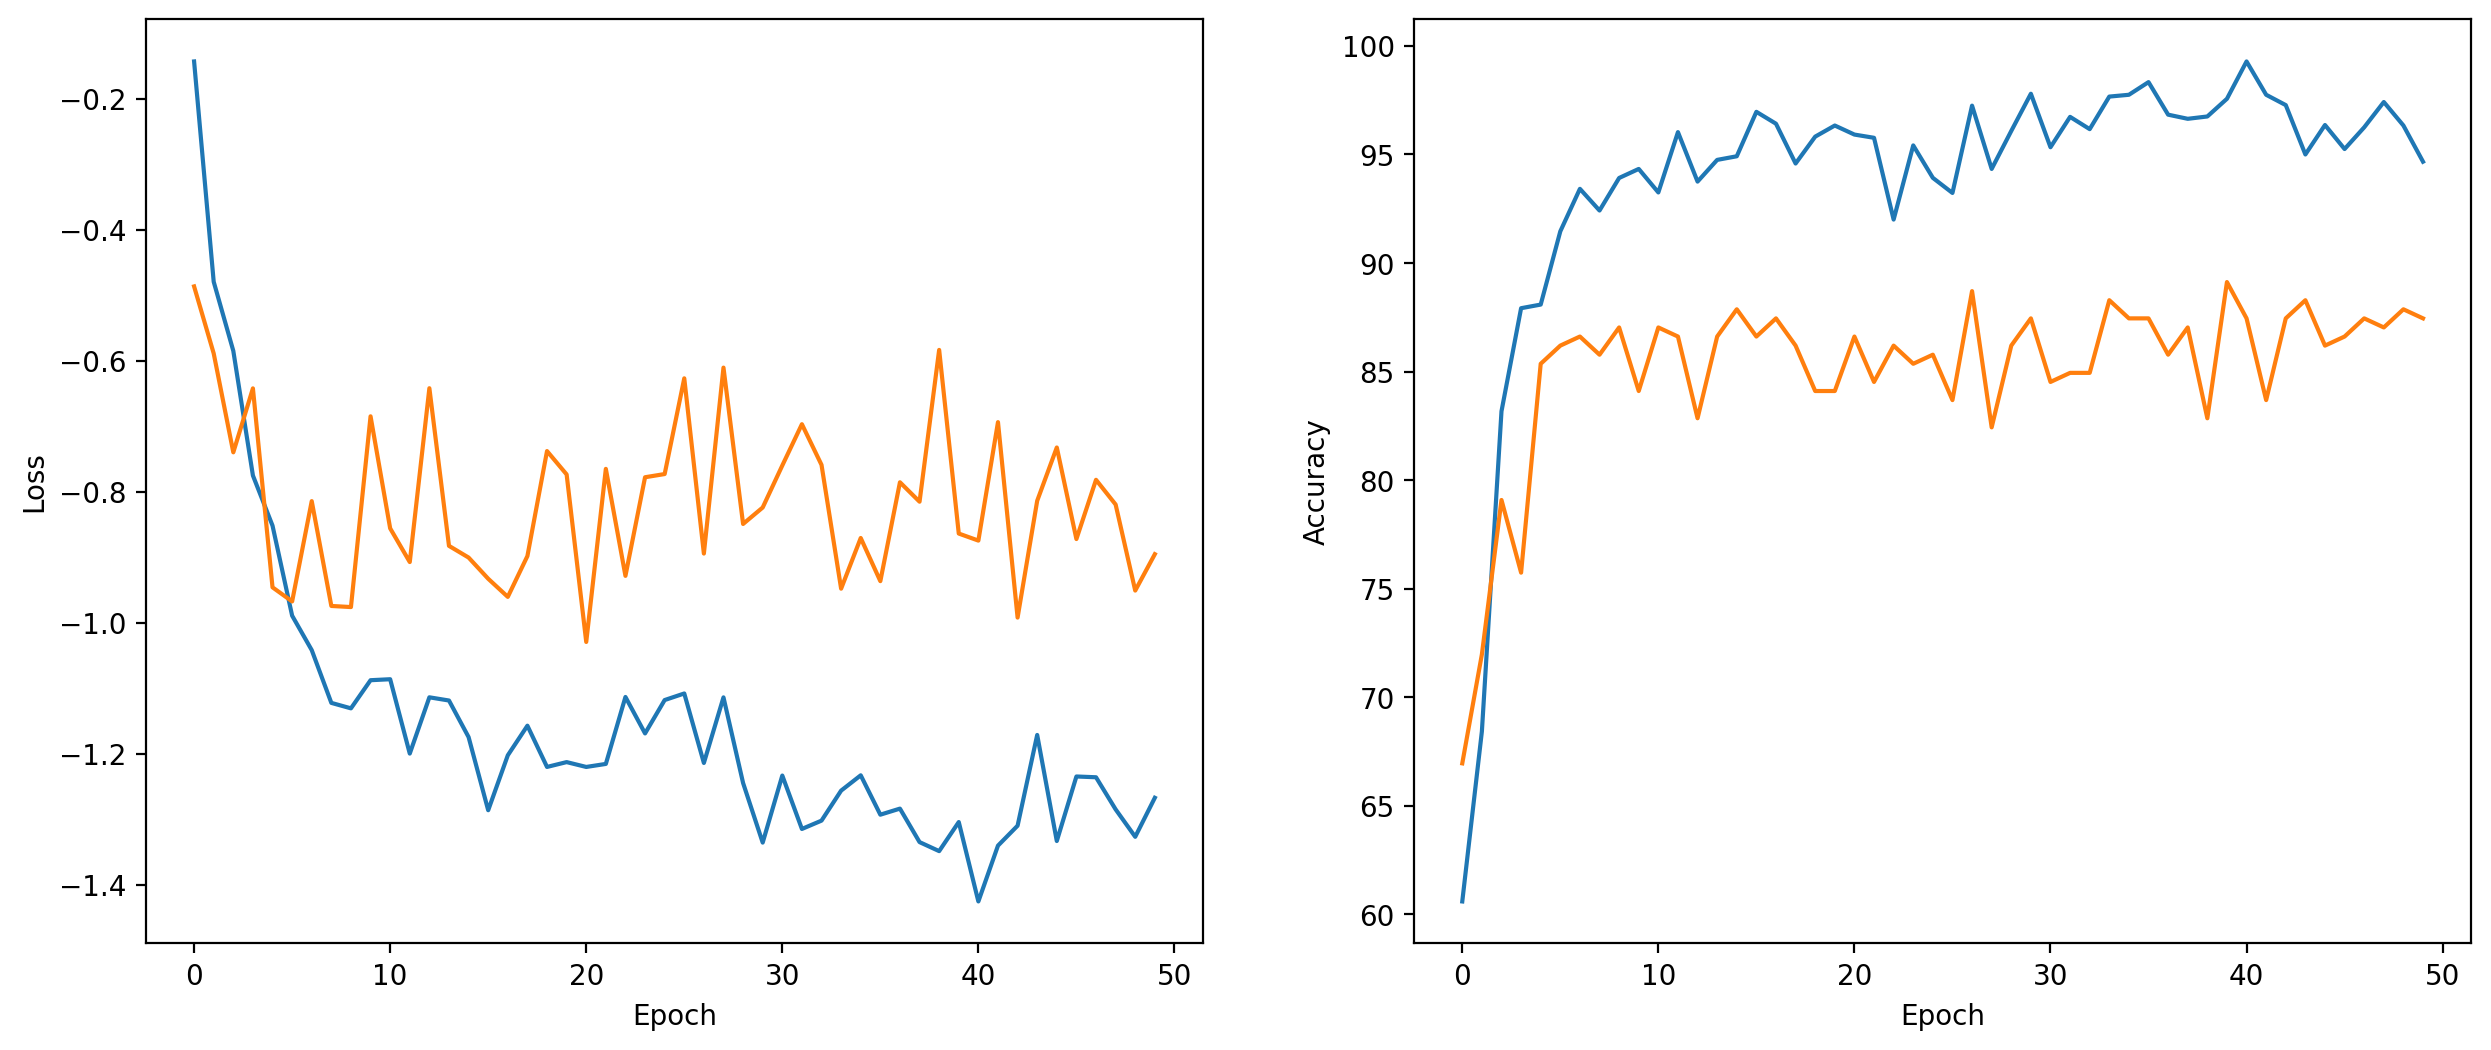

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].plot(np.log(history["train_loss"]))
axes[0].plot(np.log(history["val_loss"]))
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

axes[1].plot(100*np.array(history["train_acc"]))
axes[1].plot(100*np.array(history["val_acc"]))
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
;

In [33]:
# ### Saving the Model
# torch.save(net.state_dict(), "./model_saved_stage.pt")

In [34]:
# ### loading The Model
# net = ModelClassification(len(ROIs)*2, window_size)
# net.load_state_dict(torch.load("./model_saved_stage.pt"))
# net.to(device)
# net.eval();

## Feature importance 

In [35]:
baseline_loss, _ = evaluate_model(net, X_val_stim, y_val_stim, ROIs)
    
# Calculate feature importance using permutation
importance_loss = np.zeros(X_val.shape[1])

for i in tqdm(range(X_val.shape[1])):
    # Permute feature i
    X_permuted = X_val_stim.copy()
    np.random.shuffle(X_permuted[:, i])
    
    # Calculate accuracy with permuted feature i
    
    permuted_loss, _ = evaluate_model(net, X_permuted, y_val_stim, ROIs)

    # Calculate feature importance
    feature_importance_loss = (baseline_loss - permuted_loss) / baseline_loss
    importance_loss[i] = feature_importance_loss

# Print feature importance scores
sorted_idx_loss = np.argsort(importance_loss)[::-1]

100%|████████████████████████████████████████████| 720/720 [01:47<00:00,  6.70it/s]


In [36]:
for i in sorted_idx_loss[:20]:
    print(f"Importance of Feature {i}: {importance_loss[i]:.3f}")

Importance of Feature 259: 0.039
Importance of Feature 348: 0.019
Importance of Feature 62: 0.017
Importance of Feature 290: 0.015
Importance of Feature 144: 0.013
Importance of Feature 94: 0.013
Importance of Feature 190: 0.012
Importance of Feature 480: 0.012
Importance of Feature 229: 0.012
Importance of Feature 225: 0.012
Importance of Feature 262: 0.012
Importance of Feature 201: 0.011
Importance of Feature 222: 0.011
Importance of Feature 23: 0.011
Importance of Feature 216: 0.011
Importance of Feature 242: 0.010
Importance of Feature 355: 0.010
Importance of Feature 116: 0.010
Importance of Feature 358: 0.010
Importance of Feature 168: 0.009


In [37]:
# import pickle

# # Save
# with open('importance.pickle', 'wb') as pickle_file:
#     pickle.dump(importance_loss, pickle_file)
    
# # Load
# with open('importance.pickle', 'rb') as f:
#     importance_loss = pickle.load(f)

In [38]:
positive_importance_loss = importance_loss[:360] * (importance_loss[:360] > 0).astype(int)

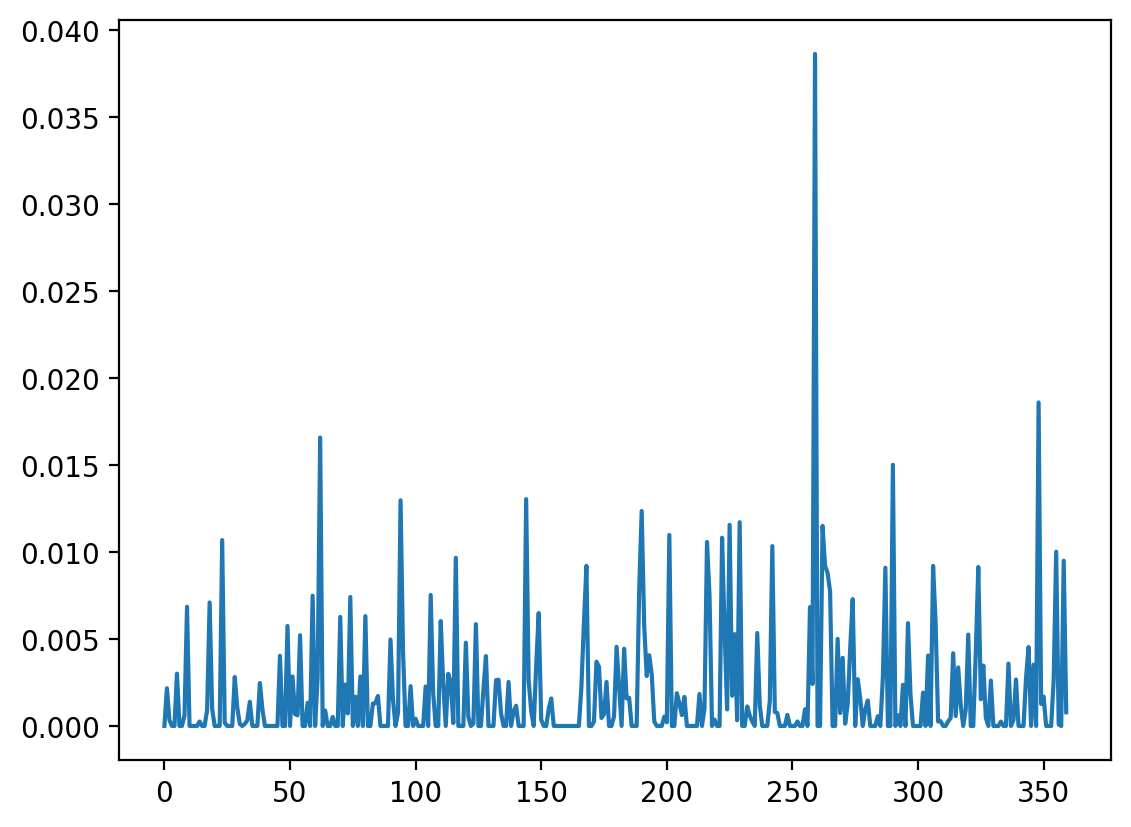

In [39]:
plt.plot(positive_importance_loss, label="loss")

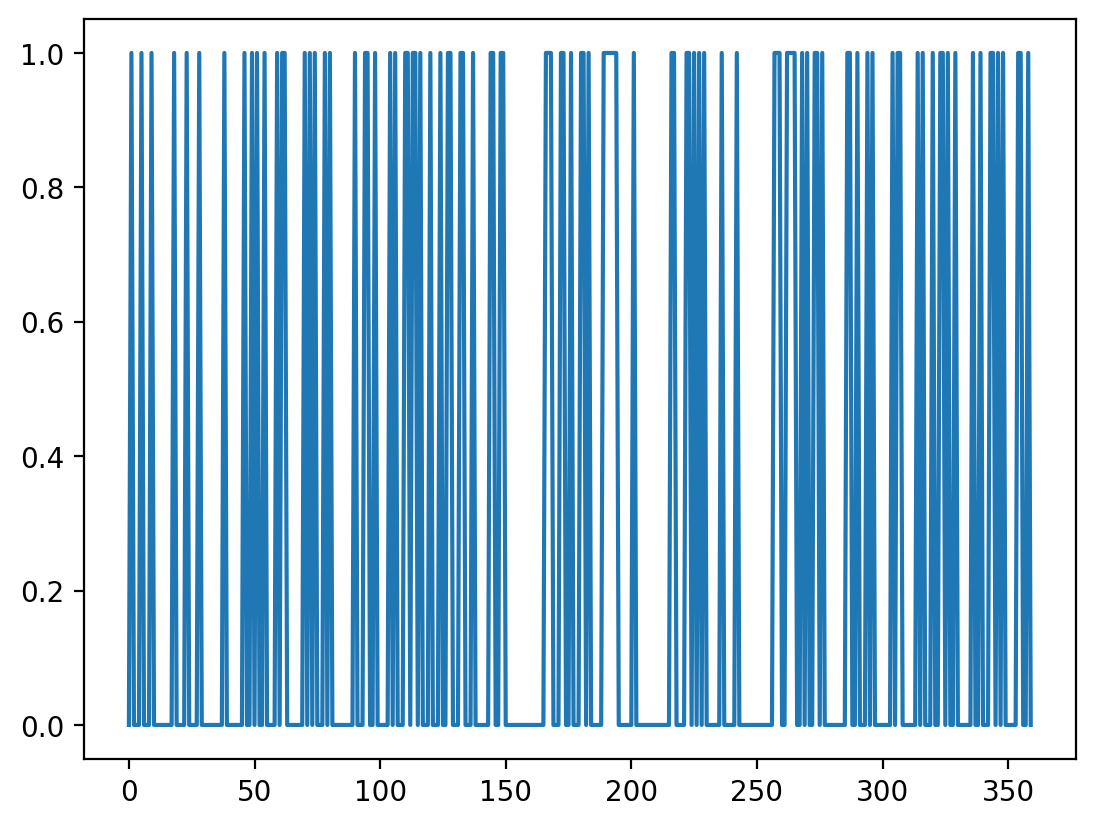

In [40]:
z_importance_loss = (positive_importance_loss - np.mean(positive_importance_loss)) / np.std(positive_importance_loss)
plt.plot((z_importance_loss > np.std(positive_importance_loss) * 2).astype(int), label="loss")

In [41]:
(z_importance_loss > np.std(positive_importance_loss) * 2).astype(int).sum()

102

In [42]:
important_features = (z_importance_loss > np.std(positive_importance_loss) * 2).astype(int)

In [43]:
pd.Series(region_info["name"])[important_features.astype(bool)].index

Int64Index([  1,   5,   9,  18,  23,  28,  38,  46,  49,  51,
            ...
            329, 336, 339, 343, 344, 346, 348, 354, 355, 358],
           dtype='int64', length=102)

In [44]:
pd.Series(pd.DataFrame(region_info["network"])[important_features.astype(bool)].\
          set_index(0).groupby(0).size()).sort_values(ascending=False)

0
Cingulo-Oper    22
Frontopariet    20
Language        11
Posterior-Mu    11
Visual2         11
Default          9
Somatomotor      7
Auditory         6
Visual1          2
Dorsal-atten     1
Orbito-Affec     1
Ventral-Mult     1
dtype: int64

In [45]:
# Sorting important ones
sorted_importance_series = pd.Series(positive_importance_loss)[important_features.astype(bool)].sort_values(ascending=False)
for _ in sorted_importance_series[:20].index:
    print(f"{_}: name:{region_info['network'][_]} importance: {sorted_importance_series[_]}")

259: name:Frontopariet importance: 0.03864104300737381
348: name:Cingulo-Oper importance: 0.018602844327688217
62: name:Frontopariet importance: 0.016586989164352417
290: name:Frontopariet importance: 0.015017269179224968
144: name:Frontopariet importance: 0.013045035302639008
94: name:Language importance: 0.012974861077964306
190: name:Cingulo-Oper importance: 0.012360074557363987
229: name:Language importance: 0.011716328561306
225: name:Language importance: 0.01156693510711193
262: name:Frontopariet importance: 0.011504493653774261
201: name:Visual2 importance: 0.010980378836393356
222: name:Cingulo-Oper importance: 0.010824055410921574
23: name:Auditory importance: 0.010687866248190403
216: name:Cingulo-Oper importance: 0.010579249821603298
242: name:Frontopariet importance: 0.0103422487154603
355: name:Posterior-Mu importance: 0.010020995512604713
116: name:Language importance: 0.009667281992733479
358: name:Cingulo-Oper importance: 0.009502059780061245
168: name:Cingulo-Oper impo

**Creating a new model by removing the last layer of the model, which will be helpful for visualizing the extracted latent space by model.**

In [46]:
net_no_classifier = nn.Sequential(*list(net.children())[0][:-2]) # removing the classifier layer

In [47]:
output_no_classify = net_no_classifier(
    torch.from_numpy(X_val_stim).to(device=device).float()
)
output_no_classify = output_no_classify.detach().cpu().numpy()

In [48]:
output_no_classify.shape

(239, 64)

# UMAP of Inputs

In [49]:
X_train_stim, y_train_stim, dict_md_train = extract_stimuli_data(X_train, idxs_train, window_size, df_subjects)

X_train_stim.shape

(959, 720, 20)

In [50]:
X_train_stim_flatten = X_train_stim.reshape((959, 720*20))
X_train_stim_flatten.shape

(959, 14400)

/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/amiralism/miniconda3/envs/bio/lib/python3.11/site-packages/uma

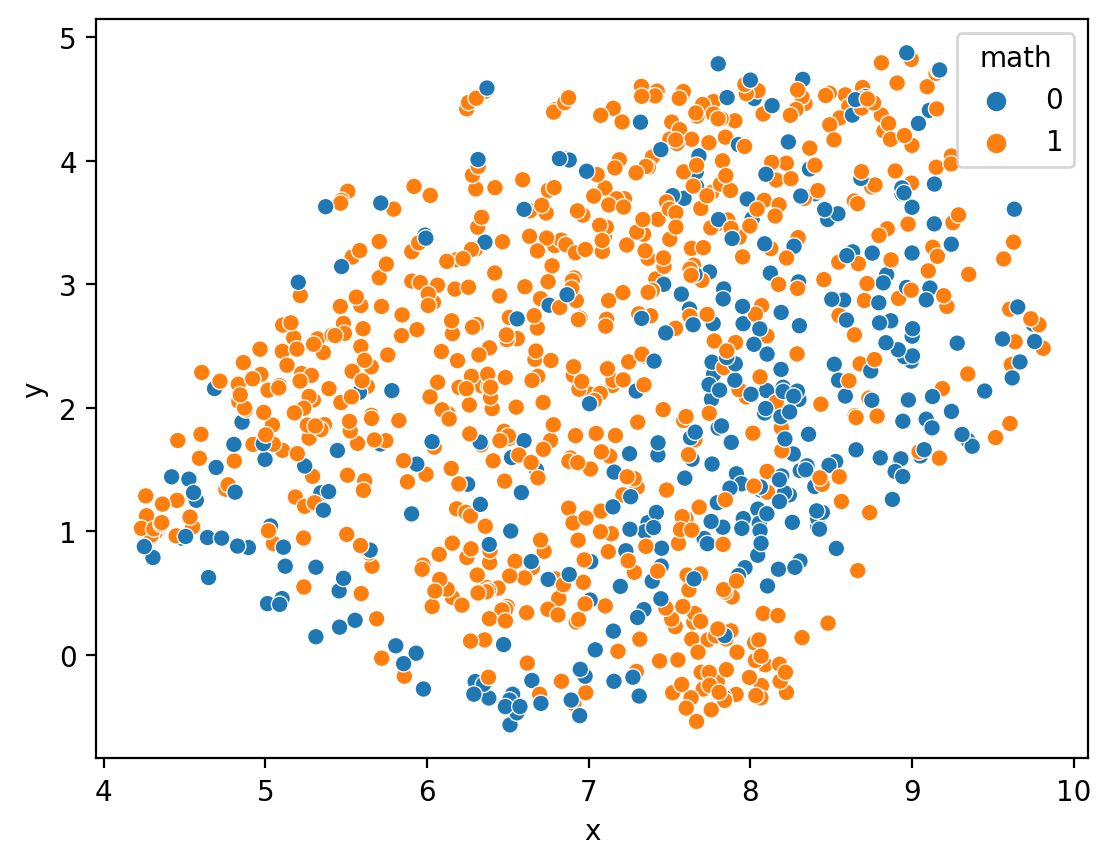

In [51]:
import seaborn as sns
import umap

mapper = umap.UMAP().fit_transform(X_train_stim_flatten)

df_to_plot = pd.DataFrame(dict_md_train)
df_to_plot["x"] = mapper[:, 0]
df_to_plot["y"] = mapper[:, 1]
df_to_plot["math"] = y_train_stim.reshape(-1)

sns.scatterplot(
    data=df_to_plot,
    x="x",
    y="y",
    hue="math"
);

# UMAP of Extracted Features 

## Validatiom Data on UMAP

### ALL

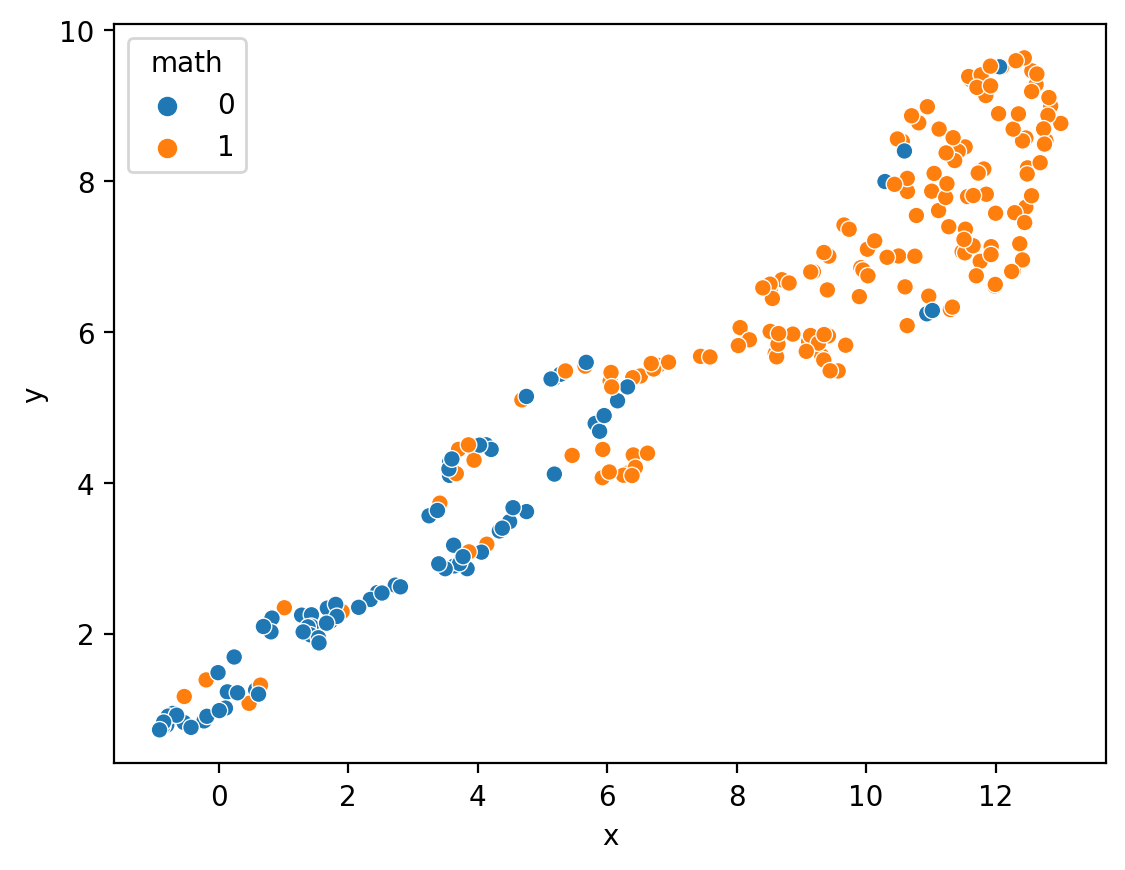

In [52]:
mapper = umap.UMAP().fit_transform(output_no_classify)

df_to_plot = pd.DataFrame(dict_md_val)
df_to_plot["x"] = mapper[:, 0]
df_to_plot["y"] = mapper[:, 1]
df_to_plot["math"] = y_val_stim.reshape(-1)

sns.scatterplot(
    data=df_to_plot,
    x="x",
    y="y",
    hue="math"
);

### Plot Only Math

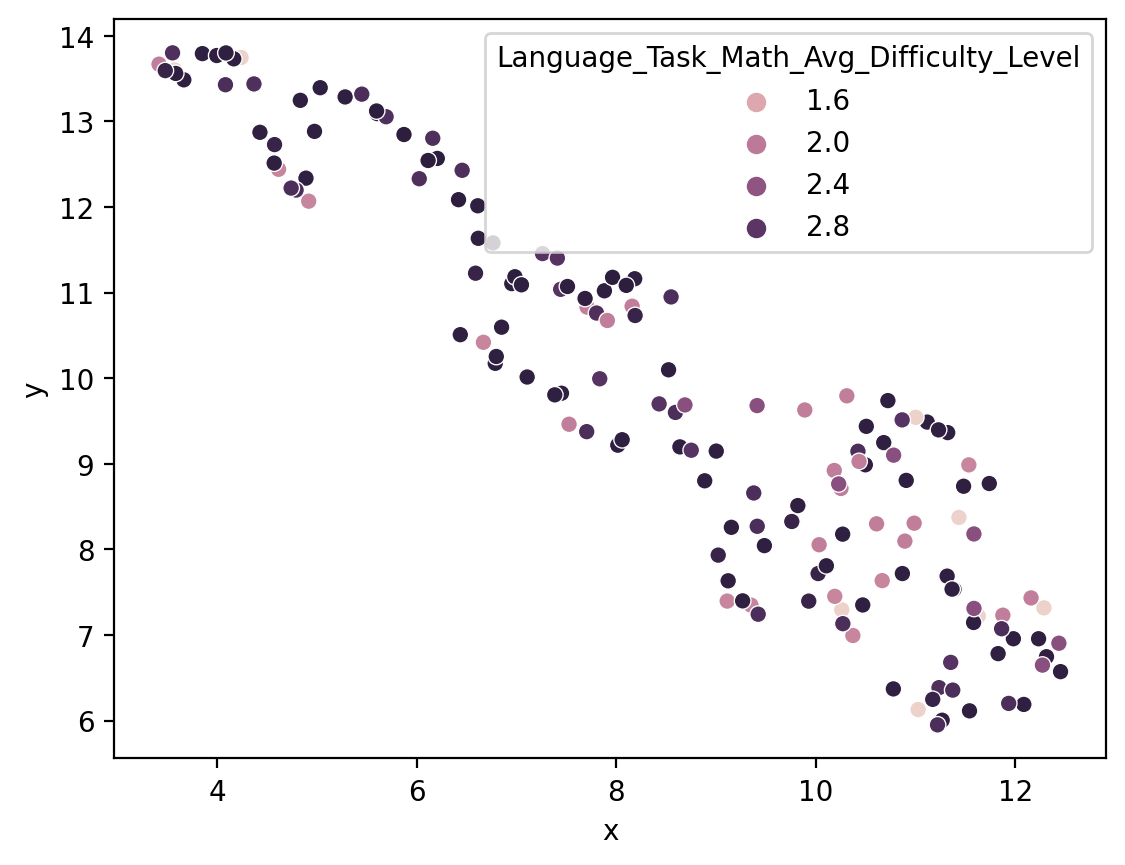

In [53]:
mask = y_val_stim.reshape(-1).astype(bool)
mapper = umap.UMAP().fit_transform(output_no_classify[mask])

df_to_plot = pd.DataFrame(dict_md_val)[mask]
df_to_plot["x"] = mapper[:, 0]
df_to_plot["y"] = mapper[:, 1]
df_to_plot["math"] = y_val_stim[mask].reshape(-1)

sns.scatterplot(
    data=df_to_plot,
    x="x",
    y="y",
    hue="Language_Task_Math_Avg_Difficulty_Level"
);

### Plot Only Story

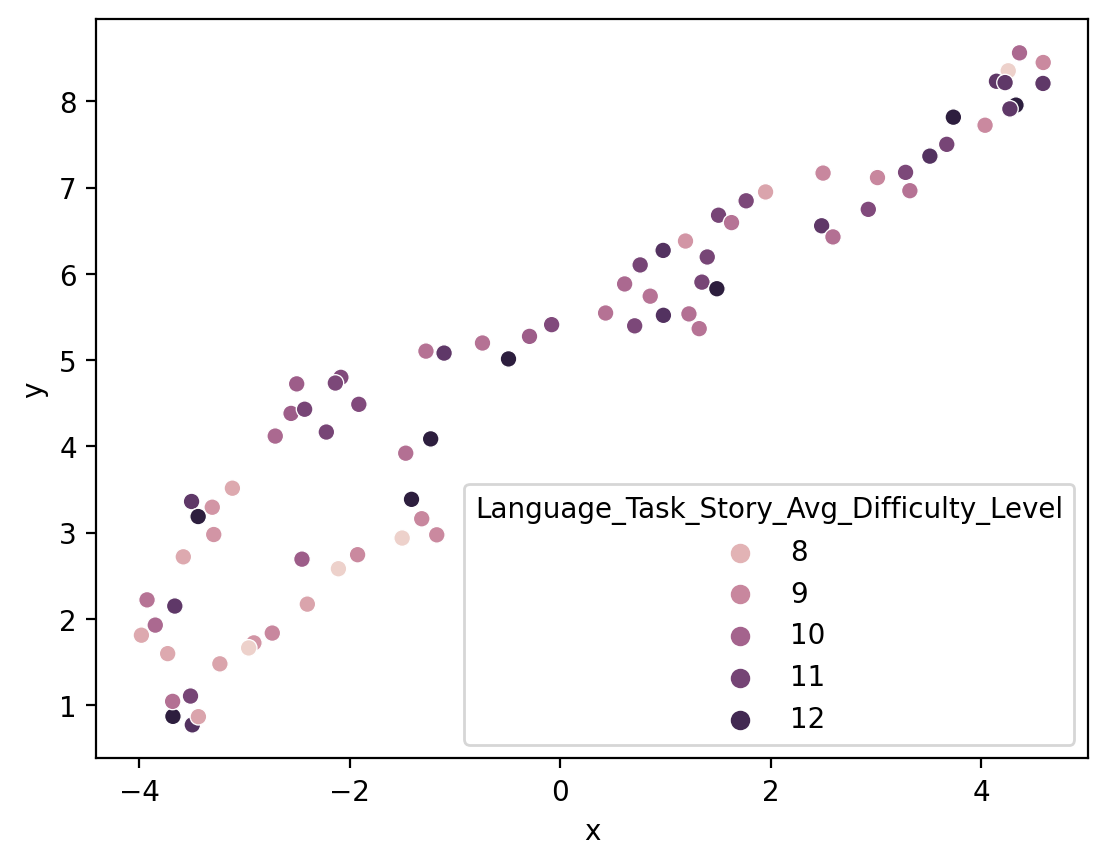

In [54]:
mask = ~y_val_stim.reshape(-1).astype(bool)
mapper = umap.UMAP().fit_transform(output_no_classify[mask])

df_to_plot = pd.DataFrame(dict_md_val)[mask]
df_to_plot["x"] = mapper[:, 0]
df_to_plot["y"] = mapper[:, 1]
df_to_plot["math"] = y_val_stim[mask].reshape(-1)

sns.scatterplot(
    data=df_to_plot,
    x="x",
    y="y",
    hue="Language_Task_Story_Avg_Difficulty_Level"
);

## Training Data on UMAP

In [55]:
with torch.no_grad():
    output_no_classify = net_no_classifier(
        torch.from_numpy(X_train_stim).to(device=device).float()
    )
    output_no_classify = output_no_classify.detach().cpu().numpy()

## ALL

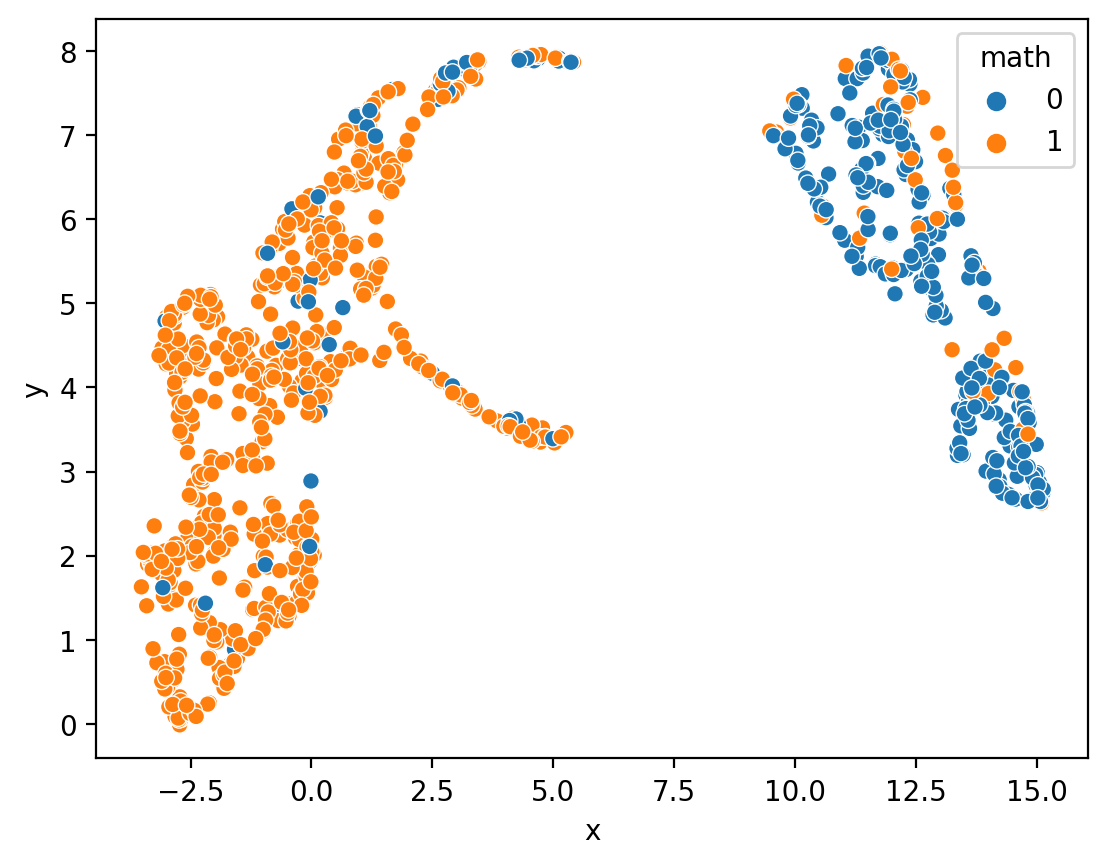

In [56]:
mapper = umap.UMAP().fit_transform(output_no_classify)

df_to_plot = pd.DataFrame(dict_md_train)
df_to_plot["x"] = mapper[:, 0]
df_to_plot["y"] = mapper[:, 1]
df_to_plot["math"] = y_train_stim.reshape(-1)

sns.scatterplot(
    data=df_to_plot,
    x="x",
    y="y",
    hue="math"
);

## Math Only

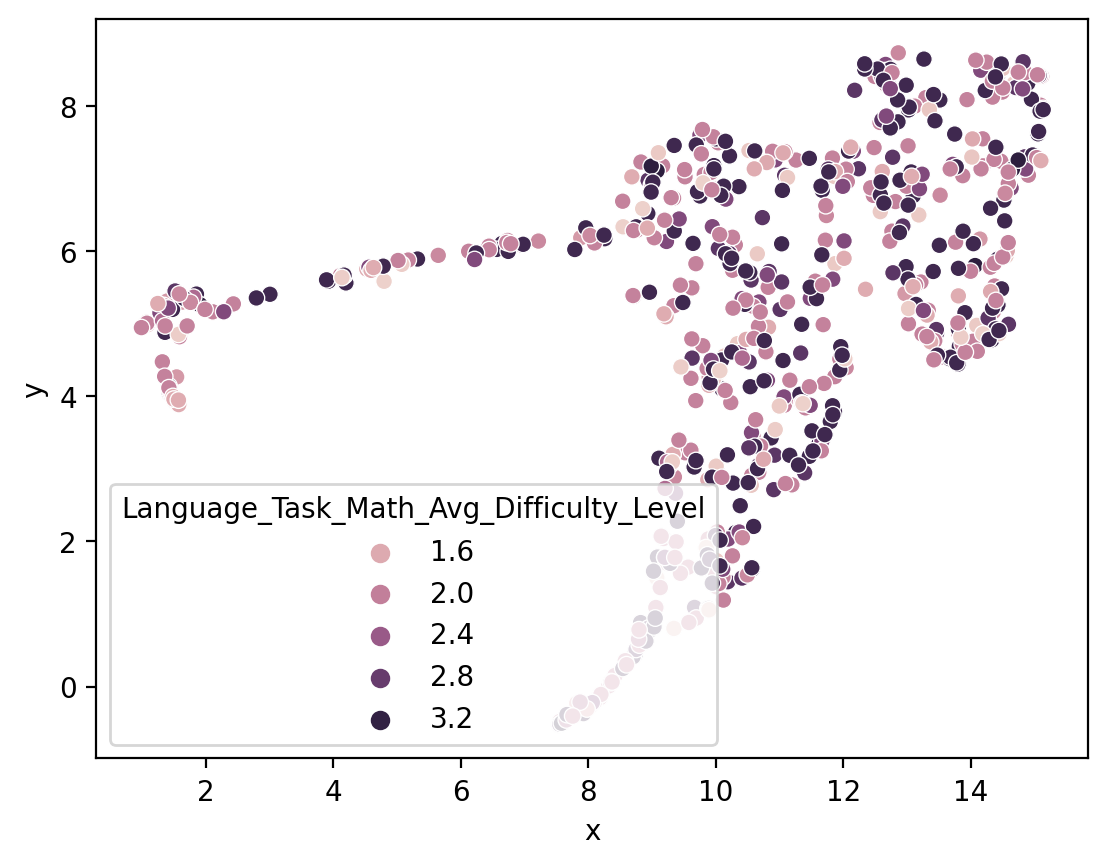

In [57]:
mask = y_train_stim.reshape(-1).astype(bool)
mapper = umap.UMAP().fit_transform(output_no_classify[mask])

df_to_plot = pd.DataFrame(dict_md_train)[mask]
df_to_plot["x"] = mapper[:, 0]
df_to_plot["y"] = mapper[:, 1]
df_to_plot["math"] = y_train_stim[mask].reshape(-1)

sns.scatterplot(
    data=df_to_plot,
    x="x",
    y="y",
    hue="Language_Task_Math_Avg_Difficulty_Level"
);

## Story Only

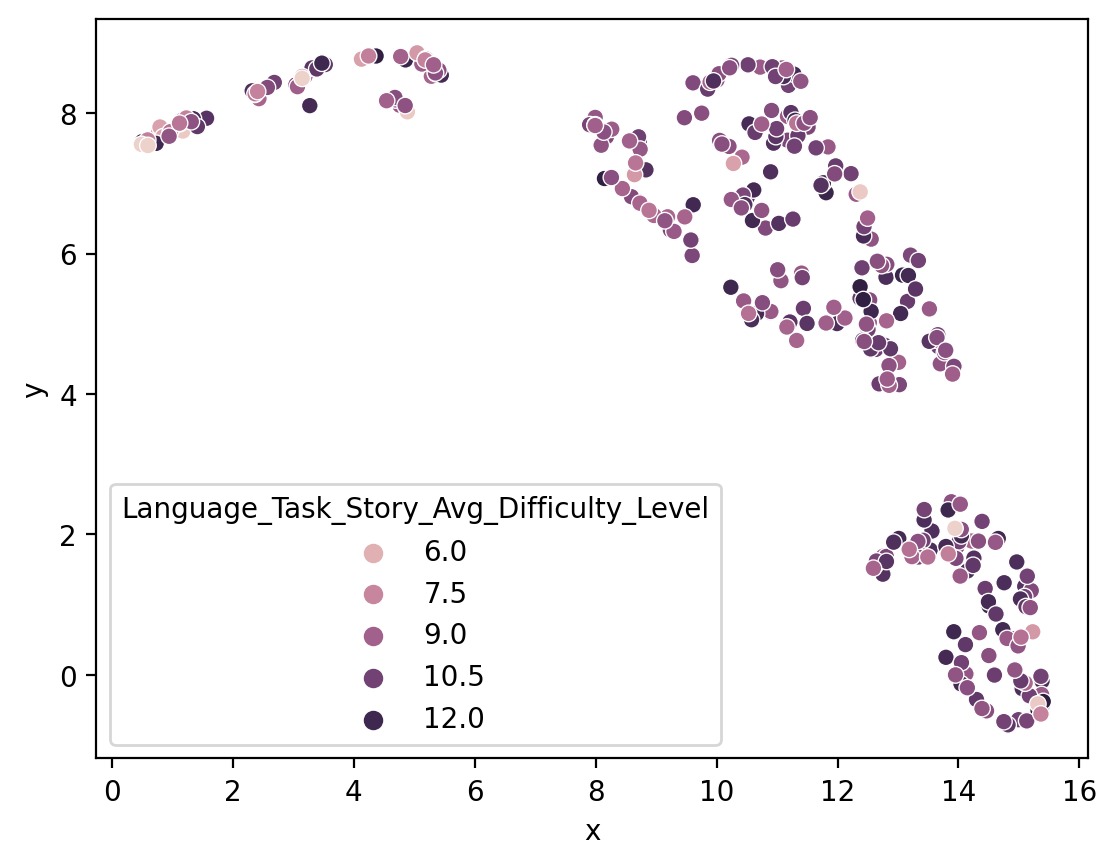

In [58]:
mask = ~y_train_stim.reshape(-1).astype(bool)
mapper = umap.UMAP().fit_transform(output_no_classify[mask])

df_to_plot = pd.DataFrame(dict_md_train)[mask]
df_to_plot["x"] = mapper[:, 0]
df_to_plot["y"] = mapper[:, 1]
df_to_plot["math"] = y_train_stim[mask].reshape(-1)

sns.scatterplot(
    data=df_to_plot,
    x="x",
    y="y",
    hue="Language_Task_Story_Avg_Difficulty_Level"
);